## Fixing the centile plots one by one

In [1]:
import os
os.chdir('/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/braincharts/scripts/')

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import matplotlib.colors
import seaborn as sns
import sys
from random import sample

from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from nm_utils import calibration_descriptives, remove_bad_subjects, load_2d

ukb_root = '/project_freenas/3022017.02/UKB'
sys.path.append(os.path.join(ukb_root,'scripts'))
from ukb_utils import get_variables_UKB, lookup_UKB
ukb_idp_dir = os.path.join(ukb_root,'phenotypes','current')
root_dir = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/braincharts'

### Load data

In [76]:
# load sex
field_codes = ['eid','31-0.0']
field_names = ['eid', 'sex']
df_sex, subs = get_variables_UKB(os.path.join(ukb_idp_dir,'01_basic_demographics.csv'), field_codes, field_names)

# load age and site
field_codes = ['eid', '21003-2.0', '54-2.0']
field_names = ['eid', 'age', 'site']
df_age, subs = get_variables_UKB(os.path.join(ukb_idp_dir,'99_miscellaneous.csv'), field_codes, field_names)

# load dMRI derived phenotypes
# field_codes = ['eid', 
#                '25059-2.0', 
#                '25101-2.0',
#                '25100-2.0', 
#                '25061-2.0',
#                '25063-2.0', 
#                '25062-2.0',
#                '25107-2.0', 
#                '25149-2.0',
#                '25148-2.0', 
#                '25109-2.0',
#                '25111-2.0',
#                '25347-2.0', 
#                '25389-2.0',
#                '25388-2.0', 
#                '25349-2.0',
#                '25351-2.0', 
#                '25350-2.0',
#                '25443-2.0', 
#                '25485-2.0',
#                '25484-2.0', 
#                '25445-2.0',
#                '25447-2.0', 
#                '25446-2.0',]
# field_names = ['eid', 
#                'Mean_FA_in_body_of_corpus_callosum_on_FA_skeleton', 
#                'Mean_FA _in_uncinate_fasciculus_on_FA_skeleton_left',
#                'Mean_FA_in_uncinate_fasciculus_on_FA_skeleton_right',
#                'Mean_FA_in_fornix_on_FA_skeleton',
#                'Mean_FA_in_corticospinal_tract_on_FA_skeleton_left',
#                'Mean_FA_in_corticospinal_tract_on_FA_skeleton_right',
#                'Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton', 
#                'Mean_MD _in_uncinate_fasciculus_on_FA_skeleton_left',
#                'Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_right',
#                'Mean_MD_in_fornix_on_FA_skeleton',
#                'Mean_MD_in_corticospinal_tract_on_FA_skeleton_left',              
#                'Mean_ICVF_in_body_of_corpus_callosum_on_FA_skeleton', 
#                'Mean_ICVF _in_uncinate_fasciculus_on_FA_skeleton_left',
#                'Mean_ICVF_in_uncinate_fasciculus_on_FA_skeleton_right',
#                'Mean_ICVF_in_fornix_on_FA_skeleton',
#                'Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_left',
#                'Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_right',
#                'Mean_ISOVF_in_body_of_corpus_callosum_on_FA_skeleton', 
#                'Mean_ISOVF _in_uncinate_fasciculus_on_FA_skeleton_left',
#                'Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_right',
#                'Mean_ISOVF_in_fornix_on_FA_skeleton',
#                'Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_left',
#                'Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_right',]
field_codes = ['eid','25107-2.0']
field_names = ['eid', 'Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton']
df_dmri, subs = get_variables_UKB(os.path.join(ukb_idp_dir,'31_brain_IDPs.csv'), field_codes, field_names)

In [117]:
dmri_data1 = df_sex.join(df_age).join(df_dmri)
dmri_data1.Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton = dmri_data1.Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton*100
dmri_data1.dropna(inplace=True)
dmri_data1.to_csv(os.path.join(root_dir,'data1_dmri.csv'))

In [118]:
np.sum(dmri_data1.Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton<0)

0

In [119]:
# 500 labeled sample
script_dir = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm'
pickled_data = os.path.join(script_dir,'500ukb_qcfeatures.pkl')
with open(pickled_data, 'rb') as f: 
    qc500_features = pickle.load(f)
qc500_path = '/home/preclineu/ramcir/Desktop/Diffusion/qc/dMRI/QC_500.csv'
qc500_labels = pd.read_csv(qc500_path)
qc500_labels["Score"] = [0 if ele > 2 else 1 for ele in qc500_labels["Score"]] # replace 3 scores with 0 and 2's with 1's
qc500_labels = qc500_labels.fillna(1) #replace nans with 1s
# Select the covariates and IDPs for the 500 subjects with labels
df_500sample = dmri_data1[dmri_data1.index.isin(qc500_labels.ID.astype(str))]

In [120]:
# where the raw data are stored
data_dir = os.path.join(root_dir,'data')

# where the analysis takes place
out_dir = os.path.join(root_dir,'models','test')

# create the output directory if it does not already exist
os.makedirs(out_dir, exist_ok=True)

### Split data

In [121]:
### Load all the subject IDs that have qc data available
pickled_data = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/subjects_qc.pkl'
with open(pickled_data, 'rb') as f: 
    subs_qc = pickle.load(f)
### Load the subjects IDs that have manual qc labels available 
pickled_data = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/labeledsubs_qc.pkl'
with open(pickled_data, 'rb') as f: 
    labeled_qc = pickle.load(f)
### Subtract the labeled subs from the total subs
keys = list(labeled_qc.columns.values)
i1 = subs_qc.set_index(keys).index
i2 = labeled_qc.set_index(keys).index
unlabeled_subs = subs_qc[~i1.isin(i2)]
print('There are', len(subs_qc), 'subjects in total')
print('There are', len(unlabeled_subs), 'subjects without manually assigned labels')
pickled_data2 = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/subs_test_5k.pkl'
with open(pickled_data2, 'rb') as f: 
    subs_test = pickle.load(f)
### Create the training subs list
keys = list(subs_test.columns.values)
i1 = unlabeled_subs.set_index(keys).index
i2 = subs_test.set_index(keys).index
subs_train = unlabeled_subs[~i1.isin(i2)]
print('There are', len(subs_train), 'subjects for training')
print('There are', len(subs_test), 'subjects for testing')
# subs_train.to_pickle('/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/subs_train_5k.pkl')

There are 23158 subjects in total
There are 22658 subjects without manually assigned labels
There are 17658 subjects for training
There are 5000 subjects for testing


In [122]:
### Create the training and testig dataset based on the subject lists
df_tr = dmri_data1[dmri_data1.index.isin(subs_train.subs)]
df_te = df_500sample
# df_te = dmri_data1[dmri_data1.index.isin(subs_test.subs)]

In [123]:
df_tr

sex     site   age  Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton
eid                                                                           
1000432  1.0  11027.0  70.0                                             0.0739
1000853  0.0  11025.0  73.0                                             0.0815
1000871  1.0  11027.0  73.0                                             0.0830
1000910  0.0  11025.0  69.0                                             0.0814
1001309  1.0  11027.0  76.0                                             0.0855
...      ...      ...   ...                                                ...
6023961  1.0  11025.0  70.0                                             0.0719
6024203  0.0  11027.0  62.0                                             0.0815
6024607  0.0  11026.0  60.0                                             0.0788
6024836  1.0  11026.0  74.0                                             0.0851
6025056  1.0  11025.0  71.0                                             0.0812

[17656 rows x 4 columns]

### Configure models

In [124]:
# with open(os.path.join(root_dir,'data','phenotypes.txt')) as f:
#     idp_ids = f.read().splitlines()
# idp_ids = ['Mean_FA_in_body_of_corpus_callosum_on_FA_skeleton', 
#                'Mean_FA _in_uncinate_fasciculus_on_FA_skeleton_left',
#                'Mean_FA_in_uncinate_fasciculus_on_FA_skeleton_right',
#                'Mean_FA_in_fornix_on_FA_skeleton',
#                'Mean_FA_in_corticospinal_tract_on_FA_skeleton_left',
#                'Mean_FA_in_corticospinal_tract_on_FA_skeleton_right',
#                'Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton', 
#                'Mean_MD _in_uncinate_fasciculus_on_FA_skeleton_left',
#                'Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_right',
#                'Mean_MD_in_fornix_on_FA_skeleton',
#                'Mean_MD_in_corticospinal_tract_on_FA_skeleton_left',               
#                'Mean_ICVF_in_body_of_corpus_callosum_on_FA_skeleton', 
#                'Mean_ICVF _in_uncinate_fasciculus_on_FA_skeleton_left',
#                'Mean_ICVF_in_uncinate_fasciculus_on_FA_skeleton_right',
#                'Mean_ICVF_in_fornix_on_FA_skeleton',
#                'Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_left',
#                'Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_right',
#                'Mean_ISOVF_in_body_of_corpus_callosum_on_FA_skeleton', 
#                'Mean_ISOVF _in_uncinate_fasciculus_on_FA_skeleton_left',
#                'Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_right',
#                'Mean_ISOVF_in_fornix_on_FA_skeleton',
#                'Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_left',
#                'Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_right']
idp_ids = ['Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton'] 
site_ids =  sorted(set(df_tr['site'].to_list()))

### Configure model parameters

In [125]:
# which data columns do we wish to use as covariates? 
cols_cov = ['age','sex']

# which warping function to use? We can set this to None in order to fit a vanilla Gaussian noise model
warp =  'WarpSinArcsinh'

# limits for cubic B-spline basis 
xmin = 40 
xmax = 90

# Do we want to force the model to be refit every time? 
force_refit = True

# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 100

### Fit the model

In [140]:
for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
   
    # set output dir 
    idp_dir = os.path.join(out_dir, idp)
    os.makedirs(os.path.join(idp_dir), exist_ok=True)
    os.chdir(idp_dir)
    
    # extract the response variables for training and test set
    y_tr = df_tr[idp].to_numpy() 
    y_te = df_te[idp].to_numpy()
    
    
    hyp0 = np.zeros(4)
    
    
    # write out the response variables for training and test
    resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_tr, y_tr)
    np.savetxt(resp_file_te, y_te)
        
    # configure the design matrix
    X_tr = create_design_matrix(df_tr[cols_cov], 
                                site_ids = df_tr['site'],
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)
    X_te = create_design_matrix(df_te[cols_cov], 
                                site_ids = df_te['site'], 
                                all_sites=site_ids,
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)

    # configure and save the covariates
    cov_file_tr = os.path.join(idp_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    np.savetxt(cov_file_tr, X_tr)
    np.savetxt(cov_file_te, X_te)

    if not force_refit and os.path.exists(os.path.join(idp_dir, 'Models', 'NM_0_0_estimate.pkl')):
        print('Making predictions using a pre-existing model...')
        suffix = 'predict'
        
        # Make prdictsion with test data
        predict(cov_file_te, 
                alg='blr', 
                respfile=resp_file_te, 
                model_path=os.path.join(idp_dir,'Models'),
                outputsuffix=suffix)
    else:
        print('Estimating the normative model...')
        estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, 
                 testcov=cov_file_te, alg='blr', optimizer = 'nelder-mead', 
                 savemodel=True, warp=warp, warp_reparam=True)
        suffix = 'estimate'

Running IDP 0 Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton :
Estimating the normative model...
Processing data in /home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/braincharts/models/test/Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.31555e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.08089e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.28337e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Optimization terminated successfully.
         Current function value: -74103.860725
         Iterations: 2
         Function evaluations: 59
Saving model meta-data...
Evaluating the model ...
Writing outputs ...


In [141]:
# initialise dataframe we will use to store quantitative metrics 
blr_metrics = pd.DataFrame(columns = ['eid', 'NLL', 'EV', 'MSLL', 'BIC','Skew','Kurtosis'])

for idp_num, idp in enumerate(idp_ids): 
    idp_dir = os.path.join(out_dir, idp)
    
    # load the predictions and true data. We use a custom function that ensures 2d arrays
    # equivalent to: y = np.loadtxt(filename); y = y[:, np.newaxis]
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_' + suffix + '.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_' + suffix + '.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
    
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # compute error metrics
    if warp is None:
        metrics = evaluate(y_te, yhat_te)  
        
        # compute MSLL manually as a sanity check
        y_tr_mean = np.array( [[np.mean(y_tr)]] )
        y_tr_var = np.array( [[np.var(y_tr)]] )
        MSLL = compute_MSLL(y_te, yhat_te, s2_te, y_tr_mean, y_tr_var)         
    else:
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        W = nm.blr.warp
        
        # warp predictions
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
       
        # evaluation metrics
        metrics = evaluate(y_te, med_te)
        
        # compute MSLL manually
        y_te_w = W.f(y_te, warp_param)
        y_tr_w = W.f(y_tr, warp_param)
        y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
        y_tr_var = np.array( [[np.var(y_tr_w)]] )
        MSLL = compute_MSLL(y_te_w, yhat_te, s2_te, y_tr_mean, y_tr_var)     
    
    Z = np.loadtxt(os.path.join(idp_dir, 'Z_' + suffix + '.txt'))
    [skew, sdskew, kurtosis, sdkurtosis, semean, sesd] = calibration_descriptives(Z)
    
    BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik
    
    blr_metrics.loc[len(blr_metrics)] = [idp, nm.neg_log_lik, metrics['EXPV'][0], 
                                         MSLL[0], BIC, skew, kurtosis]
    
display(blr_metrics)

blr_metrics.to_pickle(os.path.join(out_dir,'blr_metrics.pkl'))

AttributeError: 'NoneType' object has no attribute 'get_n_params'

### Make predictions

In [135]:
site_ids_tr = df_tr.site.unique()
site_ids_te = df_te.site.unique()

In [136]:
for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)
    
    # extract and save the response variables for the test set
    y_te = df_te[idp].to_numpy()
    y_tr = df_tr[idp].to_numpy()
    
    # save the variables
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_te, y_te)
    
    resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt') 
    np.savetxt(resp_file_tr, y_tr)
    
    # check whether all sites in the test set are represented in the training set
    if all(elem in site_ids_tr for elem in site_ids_te):
        print('All sites are present in the training data')
        
        # just make predictions
        yhat_te, s2_te, Z = predict(cov_file_te, 
                                    alg='blr', 
                                    respfile=resp_file_te, 
                                    model_path=os.path.join(idp_dir,'Models'))
    else:
        print('Some sites missing from the training data. Adapting model')
        
        # save the covariates for the adaptation data
        X_ad = create_design_matrix(df_ad[cols_cov], 
                                    site_ids = df_ad['site'],
                                    all_sites = site_ids_tr,
                                    basis = 'bspline', 
                                    xmin = xmin, 
                                    xmax = xmax)
        cov_file_ad = os.path.join(idp_dir, 'cov_bspline_ad.txt')          
        np.savetxt(cov_file_ad, X_ad)
        
        # save the responses for the adaptation data
        resp_file_ad = os.path.join(idp_dir, 'resp_ad.txt') 
        y_ad = df_ad[idp].to_numpy()
        np.savetxt(resp_file_ad, y_ad)
       
        # save the site ids for the adaptation data
        sitenum_file_ad = os.path.join(idp_dir, 'sitenum_ad.txt') 
        site_num_ad = df_ad['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_ad, site_num_ad)
        
        # save the site ids for the test data 
        sitenum_file_te = os.path.join(idp_dir, 'sitenum_te.txt')
        site_num_te = df_te['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_te, site_num_te)
         
        yhat_te, s2_te, Z = predict(cov_file_te, 
                                    alg = 'blr', 
                                    respfile = resp_file_te, 
                                    model_path = os.path.join(idp_dir,'Models'),
                                    adaptrespfile = resp_file_ad,
                                    adaptcovfile = cov_file_ad,
                                    adaptvargroupfile = sitenum_file_ad,
                                    testvargroupfile = sitenum_file_te)

Running IDP 0 Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...


/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=5.69772e-20): result may not be accurate.
  s2 = s2n + np.sum(Xs*linalg.solve(self.A, Xs.T).T, axis=1)


### Dummy data for plotting

In [137]:
# which sex do we want to plot? 
sex = 2 # 1 = male 0 = female
clr = 'grey'  
# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), 2))
X0_dummy[:,0] = xx
X0_dummy[:,1] = sex

# create the design matrix
X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, site_ids=None, all_sites=site_ids_tr)

# save the dummy covariates
cov_file_dummy = os.path.join(out_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)

configuring dummy data ...


### Plotting test data

Running IDP 0 Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.00346369]), 'Rho': array([0.46723177]), 'pRho': array([1.43447608e-29]), 'SMSE': array([0.78431405]), 'EXPV': array([0.21675468])}


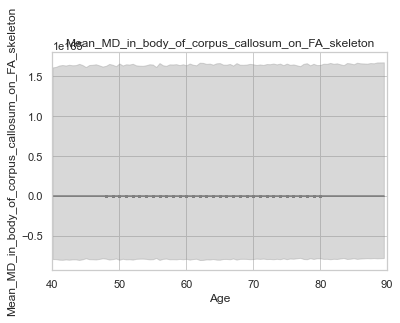

In [138]:
sns.set(style='whitegrid')

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)
    
    # load the true data points
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
            
    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')
    
    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        
    # first, we warp predictions for the true data and compute evaluation metrics
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]
    print('metrics:', evaluate(y_te, med_te))
    
    # then, we warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)
    
    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)
    
    # plot the data points
    y_te_rescaled_all = np.zeros_like(y_te)
    for sid, site in enumerate(site_ids_te):
        # plot the true test data points 
        if all(elem in site_ids_tr for elem in site_ids_te):
            # all data in the test set are present in the training set
            
            # first, we select the data points belonging to this particular site
            idx = range(0, len(X_te[:,2]))
            if len(idx) == 0:
                print('No data for site', sid, site, 'skipping...')
                continue
            
            # then directly adjust the data
            idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
            y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
        else:
            # we need to adjust the data based on the adaptation dataset 
            
            # first, select the data point belonging to this particular site
            idx = range(0, len(X_te[:,2]))
            
            # load the adaptation data
            y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
            X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
            idx_a = np.where(np.bitwise_and(X_ad[:,2] <2, (df_ad['site'] == site).to_numpy()))[0]
            if len(idx) < 2 or len(idx_a) < 2:
                print('Insufficent data for site', sid, site, 'skipping...')
                continue
            
            # adjust and rescale the data
            y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                   X_ad[idx_a,:], 
                                                                   np.squeeze(y_ad[idx_a]), 
                                                                   Xs=None, 
                                                                   ys=np.squeeze(y_te[idx]))
        # plot the (adjusted) data points
        plt.scatter(X_te[idx,1], y_te_rescaled, s=4, color=clr, alpha = 1)
       
    # plot the median of the dummy data
    plt.plot(xx, med, clr)
    
    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)
            
    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)
    
    plt.xlabel('Age')
    plt.ylabel(idp) 
    plt.title(idp)
    plt.xlim((40,90))
#     plt.ylim((np.mean(y_te_rescaled)-15*np.std(y_te_rescaled)), (np.mean(y_te_rescaled)+15*np.std(y_te_rescaled)))
    plt.savefig(os.path.join(idp_dir, 'test_data'))
    plt.show()
    
os.chdir(out_dir)

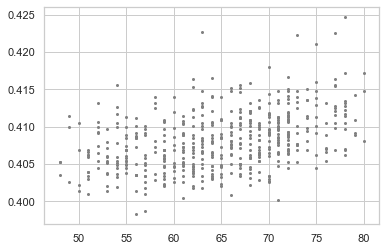

In [139]:
plt.scatter(X_te[idx,1], y_te_rescaled, s=4, color=clr, alpha = 1)

### Plotting training data

Running IDP 0 Mean_FA_in_body_of_corpus_callosum_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02828599]), 'Rho': array([0.31218191]), 'pRho': array([6.02424311e-13]), 'SMSE': array([0.91615489]), 'EXPV': array([0.09719763])}


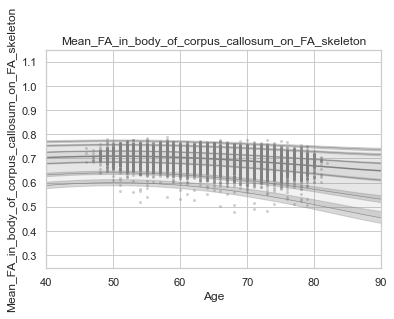

Running IDP 1 Mean_FA _in_uncinate_fasciculus_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03885709]), 'Rho': array([0.21740295]), 'pRho': array([8.42435519e-07]), 'SMSE': array([0.95497484]), 'EXPV': array([0.04517013])}


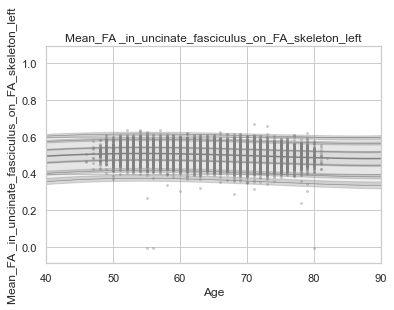

Running IDP 2 Mean_FA_in_uncinate_fasciculus_on_FA_skeleton_right :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03720623]), 'Rho': array([0.14625041]), 'pRho': array([0.00102351]), 'SMSE': array([0.98089796]), 'EXPV': array([0.02088551])}


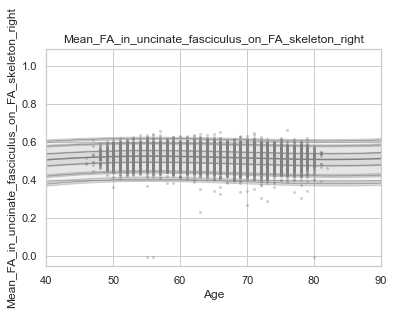

Running IDP 3 Mean_FA_in_fornix_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.07758366]), 'Rho': array([0.51019008]), 'pRho': array([3.92808049e-36]), 'SMSE': array([0.74953782]), 'EXPV': array([0.25993443])}


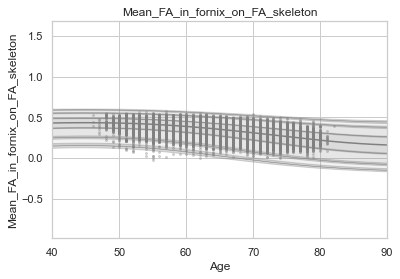

Running IDP 4 Mean_FA_in_corticospinal_tract_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0329012]), 'Rho': array([0.25173858]), 'pRho': array([9.72784942e-09]), 'SMSE': array([0.93761316]), 'EXPV': array([0.06329403])}


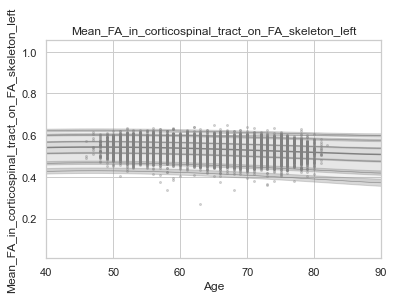

Running IDP 5 Mean_FA_in_corticospinal_tract_on_FA_skeleton_right :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03643608]), 'Rho': array([0.31694022]), 'pRho': array([2.52329969e-13]), 'SMSE': array([0.89971918]), 'EXPV': array([0.10029995])}


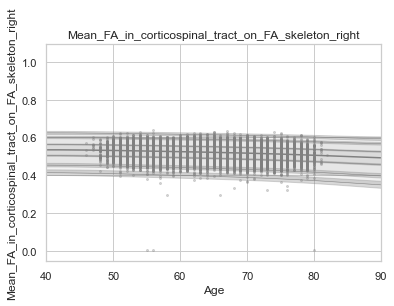

Running IDP 6 Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.46299049e-05]), 'Rho': array([0.46753471]), 'pRho': array([1.30008482e-29]), 'SMSE': array([0.78399825]), 'EXPV': array([0.21704434])}


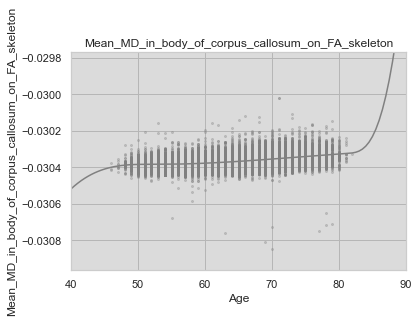

Running IDP 7 Mean_MD _in_uncinate_fasciculus_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.59414553e-05]), 'Rho': array([0.31186614]), 'pRho': array([6.37865985e-13]), 'SMSE': array([0.91417163]), 'EXPV': array([0.09469046])}


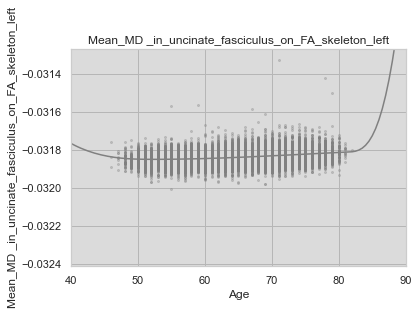

Running IDP 8 Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_right :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.07593182e-05]), 'Rho': array([0.31994812]), 'pRho': array([1.44326454e-13]), 'SMSE': array([0.89901648]), 'EXPV': array([0.10130028])}


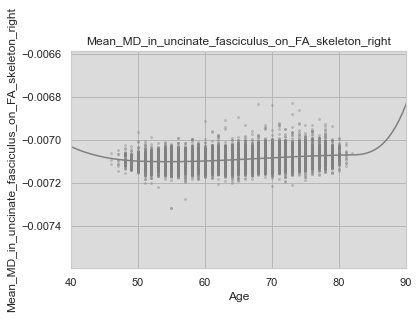

Running IDP 9 Mean_MD_in_fornix_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.00028218]), 'Rho': array([0.49521617]), 'pRho': array([1.00333932e-33]), 'SMSE': array([0.7555302]), 'EXPV': array([0.24480509])}


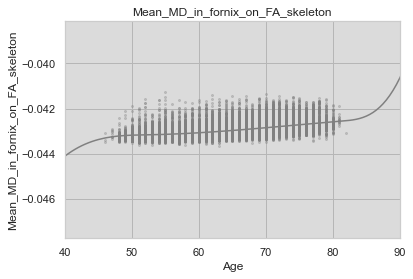

Running IDP 10 Mean_MD_in_corticospinal_tract_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([6.91346574e-05]), 'Rho': array([0.09407078]), 'pRho': array([0.03543205]), 'SMSE': array([0.99377579]), 'EXPV': array([0.00854673])}


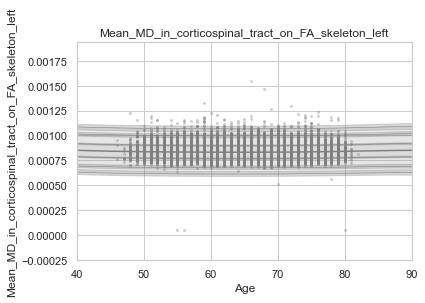

Running IDP 11 Mean_ICVF_in_body_of_corpus_callosum_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03275015]), 'Rho': array([0.16055541]), 'pRho': array([0.00030551]), 'SMSE': array([0.97700142]), 'EXPV': array([0.02316768])}


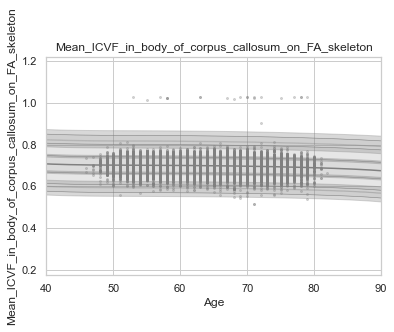

Running IDP 12 Mean_ICVF _in_uncinate_fasciculus_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02830092]), 'Rho': array([0.33387099]), 'pRho': array([9.95540877e-15]), 'SMSE': array([0.88961839]), 'EXPV': array([0.11074664])}


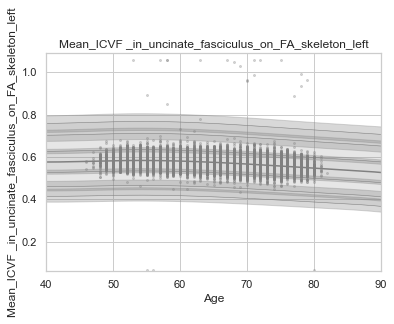

Running IDP 13 Mean_ICVF_in_uncinate_fasciculus_on_FA_skeleton_right :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02806532]), 'Rho': array([0.33348161]), 'pRho': array([1.07499068e-14]), 'SMSE': array([0.89004238]), 'EXPV': array([0.11011764])}


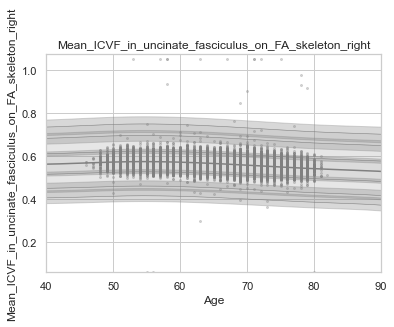

Running IDP 14 Mean_ICVF_in_fornix_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06654167]), 'Rho': array([0.23242234]), 'pRho': array([1.3063383e-07]), 'SMSE': array([0.94728316]), 'EXPV': array([0.05297758])}


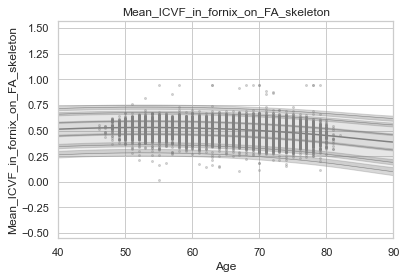

Running IDP 15 Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04328906]), 'Rho': array([0.18281915]), 'pRho': array([3.75567802e-05]), 'SMSE': array([0.96759402]), 'EXPV': array([0.03299898])}


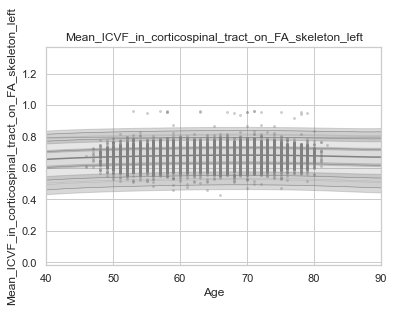

Running IDP 16 Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_right :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04322999]), 'Rho': array([0.28237831]), 'pRho': array([9.73484499e-11]), 'SMSE': array([0.92241283]), 'EXPV': array([0.07860435])}


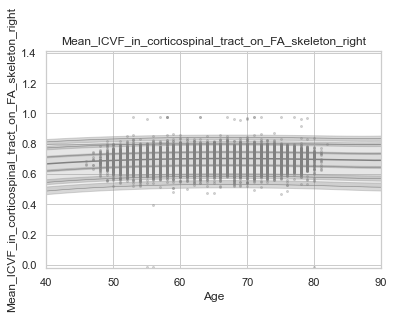

Running IDP 17 Mean_ISOVF_in_body_of_corpus_callosum_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01725591]), 'Rho': array([0.49782746]), 'pRho': array([3.90184716e-34]), 'SMSE': array([0.76092552]), 'EXPV': array([0.24718992])}


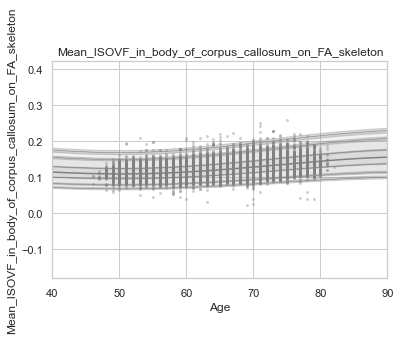

Running IDP 18 Mean_ISOVF _in_uncinate_fasciculus_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01418145]), 'Rho': array([0.17043107]), 'pRho': array([0.00012457]), 'SMSE': array([1.0600328]), 'EXPV': array([0.02302973])}


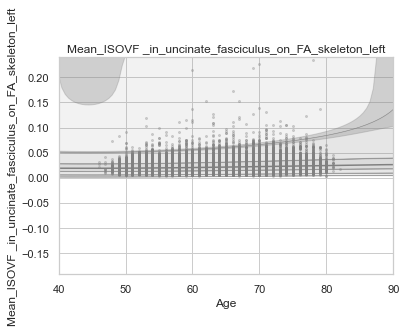

Running IDP 19 Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_right :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0121364]), 'Rho': array([0.24179389]), 'pRho': array([3.81243891e-08]), 'SMSE': array([1.00050324]), 'EXPV': array([0.0499226])}


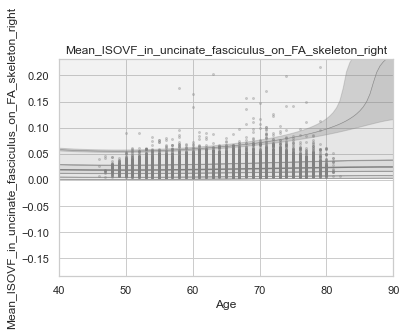

Running IDP 20 Mean_ISOVF_in_fornix_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11936112]), 'Rho': array([0.54596378]), 'pRho': array([1.82670518e-42]), 'SMSE': array([0.70887682]), 'EXPV': array([0.29792001])}


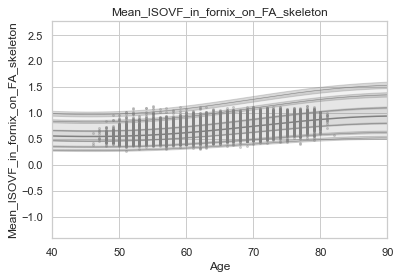

Running IDP 21 Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04571328]), 'Rho': array([0.08585862]), 'pRho': array([0.05500798]), 'SMSE': array([0.9987373]), 'EXPV': array([0.00617926])}


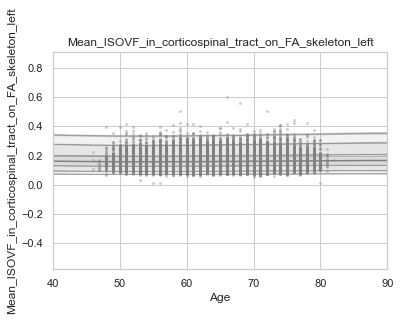

Running IDP 22 Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_right :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.05512299]), 'Rho': array([0.13336526]), 'pRho': array([0.00278069]), 'SMSE': array([1.00280271]), 'EXPV': array([0.01015687])}


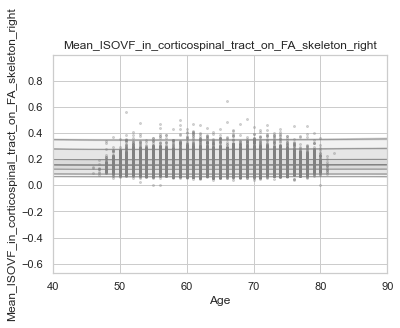

In [74]:
sns.set(style='whitegrid')

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)
    
    # load the true data points
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
    y_tr = load_2d(os.path.join(idp_dir, 'resp_tr.txt'))
            
    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')
    
    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        
    # first, we warp predictions for the true data and compute evaluation metrics
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]
    print('metrics:', evaluate(y_te, med_te))
    
    # then, we warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)
    
    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)
    
    # plot the data points
    y_te_rescaled_all = np.zeros_like(y_te)
    for sid, site in enumerate(site_ids_te):
        # plot the true test data points 
        if all(elem in site_ids_tr for elem in site_ids_te):
            # all data in the test set are present in the training set
            
            # first, we select the data points belonging to this particular site
            idx = range(0, len(X_tr[:,2]))
            if len(idx) == 0:
                print('No data for site', sid, site, 'skipping...')
                continue
            
            # then directly adjust the data
#             idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
            idx_dummy = np.bitwise_and(X_dummy[:,1] > df_tr['age'].min(), X_dummy[:,1] < df_tr['age'].max())
#             y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
            y_tr_rescaled = y_tr[idx] - np.median(y_tr[idx]) + np.median(med[idx_dummy])
        else:
            print('else')
            # we need to adjust the data based on the adaptation dataset 
            
            # first, select the data point belonging to this particular site
            idx = range(0, len(X_te[:,2]))
            
            # load the adaptation data
            y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
            X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
            idx_a = np.where(np.bitwise_and(X_ad[:,2] <2, (df_ad['site'] == site).to_numpy()))[0]
            if len(idx) < 2 or len(idx_a) < 2:
                print('Insufficent data for site', sid, site, 'skipping...')
                continue
            
            # adjust and rescale the data
            y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                   X_ad[idx_a,:], 
                                                                   np.squeeze(y_ad[idx_a]), 
                                                                   Xs=None, 
                                                                   ys=np.squeeze(y_te[idx]))
            y_tr_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                   X_ad[idx_a,:], 
                                                                   np.squeeze(y_ad[idx_a]), 
                                                                   Xs=None, 
                                                                   ys=np.squeeze(y_tr[idx]))
        # plot the (adjusted) data points
        plt.scatter(df_tr['age'], y_tr_rescaled, s=4, color=clr, alpha = 0.1)
       
    # plot the median of the dummy data
    plt.plot(xx, med, clr)
    
    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)
            
    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)
    
    plt.xlabel('Age')
    plt.ylabel(idp) 
    plt.title(idp)
    plt.xlim((40,90))
#     plt.ylim((0,1))
    plt.ylim((np.mean(y_tr_rescaled)-15*np.std(y_tr_rescaled)), (np.mean(y_tr_rescaled)+15*np.std(y_tr_rescaled)))
    plt.savefig(os.path.join(idp_dir, 'training_data'))
    plt.show()
    
os.chdir(out_dir)

### Subplotting

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02828599]), 'Rho': array([0.31218191]), 'pRho': array([6.02424311e-13]), 'SMSE': array([0.91615489]), 'EXPV': array([0.09719763])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02828599]), 'Rho': array([0.31218191]), 'pRho': array([6.02424311e-13]), 'SMSE': array([0.91615489]), 'EXPV': array([0.09719763])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02828599]), 'Rho': array([0.31218191]), 'pRho': array([6.02424311e-13]), 'SMSE': array([0.91615489]), 'EXPV': array([0.09719763])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': arra

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02828599]), 'Rho': array([0.31218191]), 'pRho': array([6.02424311e-13]), 'SMSE': array([0.91615489]), 'EXPV': array([0.09719763])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


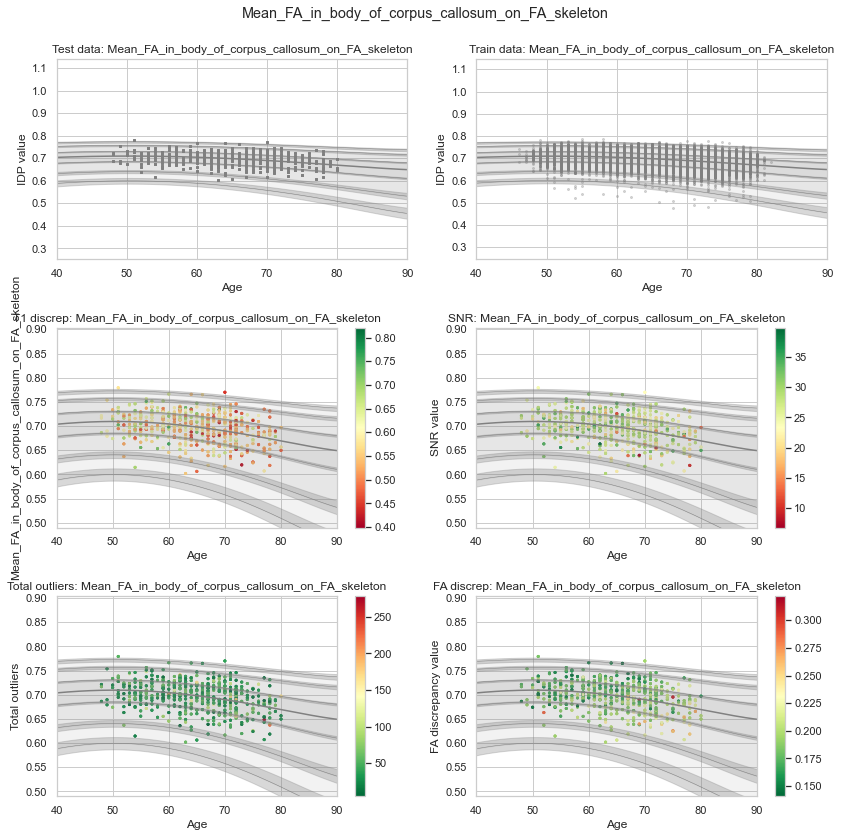

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03885709]), 'Rho': array([0.21740295]), 'pRho': array([8.42435519e-07]), 'SMSE': array([0.95497484]), 'EXPV': array([0.04517013])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03885709]), 'Rho': array([0.21740295]), 'pRho': array([8.42435519e-07]), 'SMSE': array([0.95497484]), 'EXPV': array([0.04517013])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03885709]), 'Rho': array([0.21740295]), 'pRho': array([8.42435519e-07]), 'SMSE': array([0.95497484]), 'EXPV': array([0.04517013])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': arra

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03885709]), 'Rho': array([0.21740295]), 'pRho': array([8.42435519e-07]), 'SMSE': array([0.95497484]), 'EXPV': array([0.04517013])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


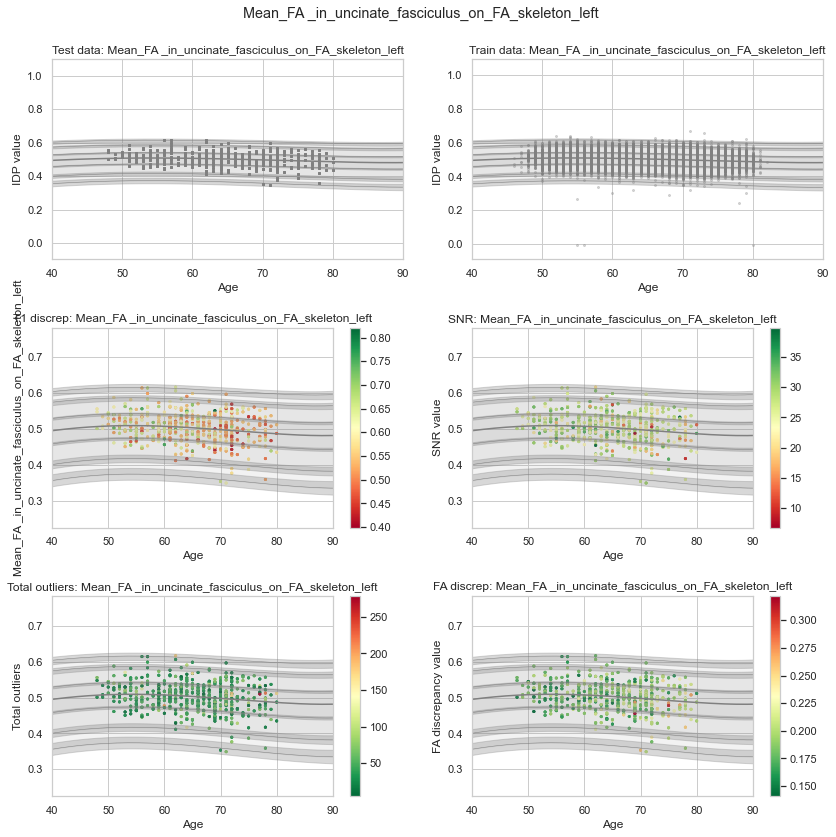

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03720623]), 'Rho': array([0.14625041]), 'pRho': array([0.00102351]), 'SMSE': array([0.98089796]), 'EXPV': array([0.02088551])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03720623]), 'Rho': array([0.14625041]), 'pRho': array([0.00102351]), 'SMSE': array([0.98089796]), 'EXPV': array([0.02088551])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03720623]), 'Rho': array([0.14625041]), 'pRho': array([0.00102351]), 'SMSE': array([0.98089796]), 'EXPV': array([0.02088551])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0372062

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03720623]), 'Rho': array([0.14625041]), 'pRho': array([0.00102351]), 'SMSE': array([0.98089796]), 'EXPV': array([0.02088551])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03720623]), 'Rho': array([0.14625041]), 'pRho': array([0.00102351]), 'SMSE': array([0.98089796]), 'EXPV': array([0.02088551])}


/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


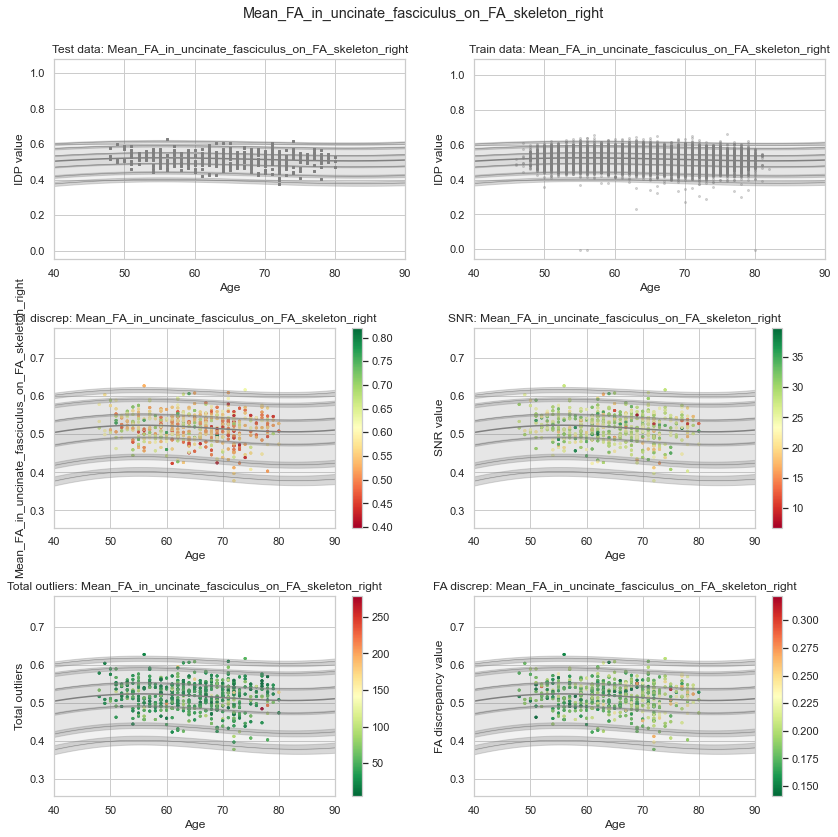

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.07758366]), 'Rho': array([0.51019008]), 'pRho': array([3.92808049e-36]), 'SMSE': array([0.74953782]), 'EXPV': array([0.25993443])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.07758366]), 'Rho': array([0.51019008]), 'pRho': array([3.92808049e-36]), 'SMSE': array([0.74953782]), 'EXPV': array([0.25993443])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.07758366]), 'Rho': array([0.51019008]), 'pRho': array([3.92808049e-36]), 'SMSE': array([0.74953782]), 'EXPV': array([0.25993443])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': arra

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


metrics: {'RMSE': array([0.07758366]), 'Rho': array([0.51019008]), 'pRho': array([3.92808049e-36]), 'SMSE': array([0.74953782]), 'EXPV': array([0.25993443])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.07758366]), 'Rho': array([0.51019008]), 'pRho': array([3.92808049e-36]), 'SMSE': array([0.74953782]), 'EXPV': array([0.25993443])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


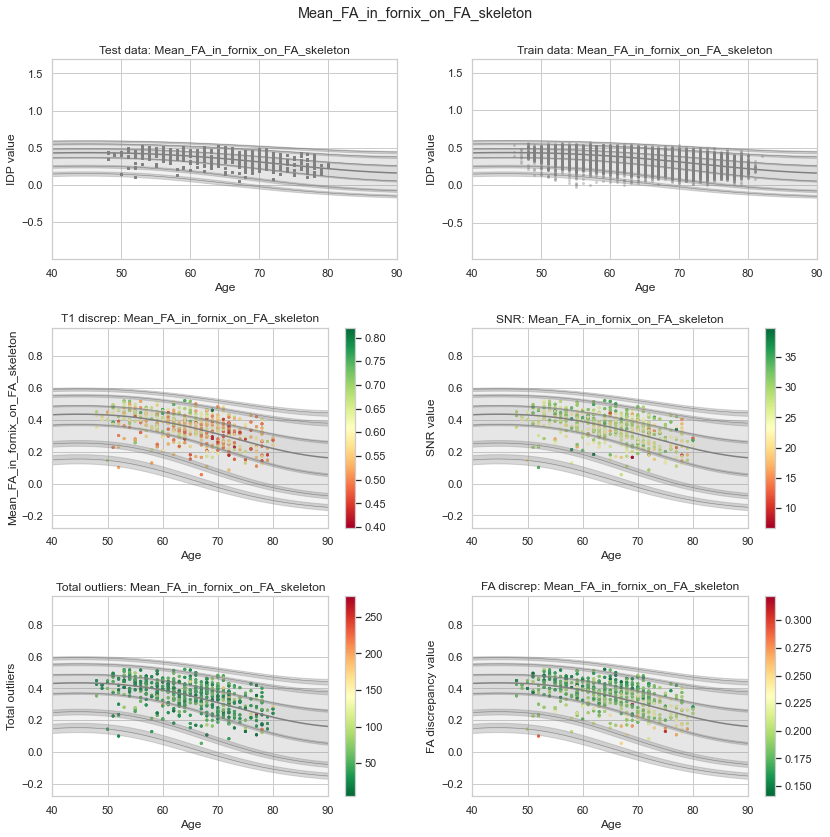

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0329012]), 'Rho': array([0.25173858]), 'pRho': array([9.72784942e-09]), 'SMSE': array([0.93761316]), 'EXPV': array([0.06329403])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0329012]), 'Rho': array([0.25173858]), 'pRho': array([9.72784942e-09]), 'SMSE': array([0.93761316]), 'EXPV': array([0.06329403])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0329012]), 'Rho': array([0.25173858]), 'pRho': array([9.72784942e-09]), 'SMSE': array([0.93761316]), 'EXPV': array([0.06329403])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


metrics: {'RMSE': array([0.0329012]), 'Rho': array([0.25173858]), 'pRho': array([9.72784942e-09]), 'SMSE': array([0.93761316]), 'EXPV': array([0.06329403])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0329012]), 'Rho': array([0.25173858]), 'pRho': array([9.72784942e-09]), 'SMSE': array([0.93761316]), 'EXPV': array([0.06329403])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


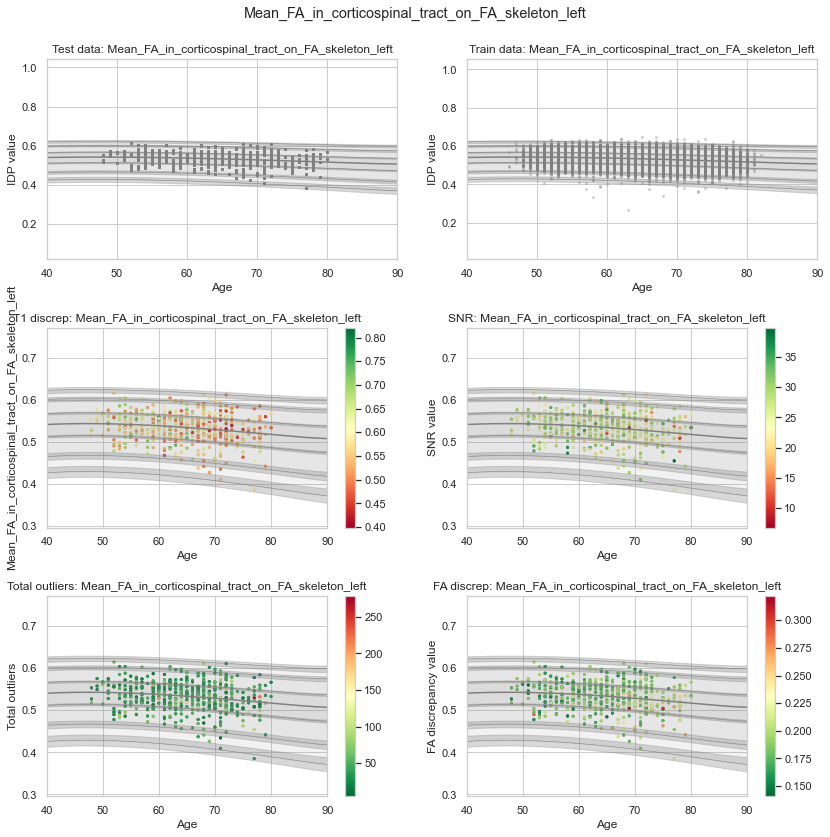

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03643608]), 'Rho': array([0.31694022]), 'pRho': array([2.52329969e-13]), 'SMSE': array([0.89971918]), 'EXPV': array([0.10029995])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03643608]), 'Rho': array([0.31694022]), 'pRho': array([2.52329969e-13]), 'SMSE': array([0.89971918]), 'EXPV': array([0.10029995])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03643608]), 'Rho': array([0.31694022]), 'pRho': array([2.52329969e-13]), 'SMSE': array([0.89971918]), 'EXPV': array([0.10029995])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': arra

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03643608]), 'Rho': array([0.31694022]), 'pRho': array([2.52329969e-13]), 'SMSE': array([0.89971918]), 'EXPV': array([0.10029995])}


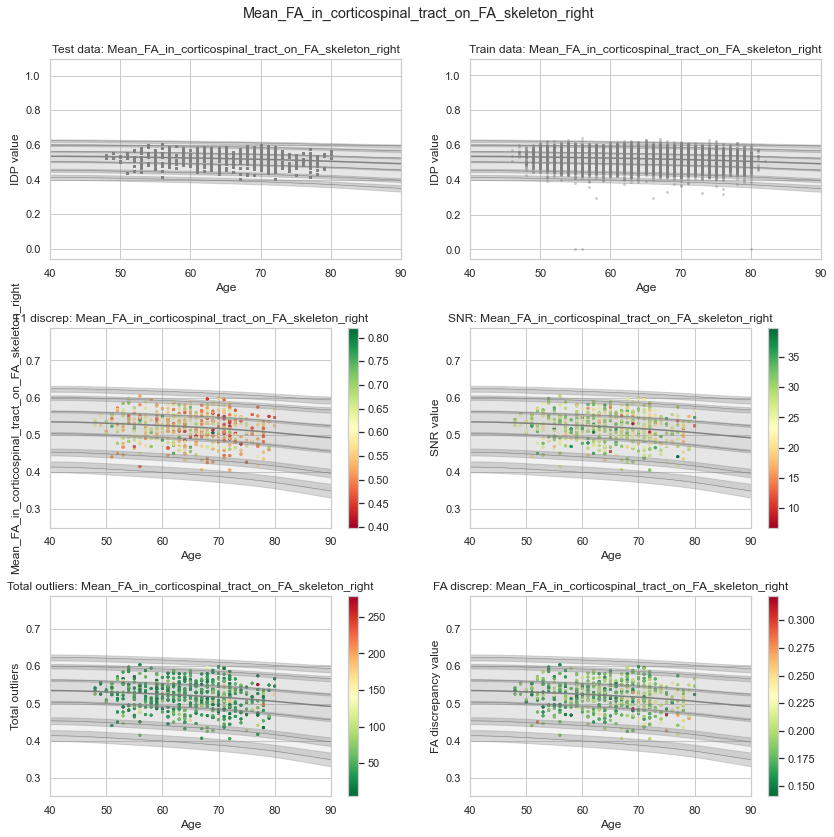

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.46299049e-05]), 'Rho': array([0.46753471]), 'pRho': array([1.30008482e-29]), 'SMSE': array([0.78399825]), 'EXPV': array([0.21704434])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.46299049e-05]), 'Rho': array([0.46753471]), 'pRho': array([1.30008482e-29]), 'SMSE': array([0.78399825]), 'EXPV': array([0.21704434])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.46299049e-05]), 'Rho': array([0.46753471]), 'pRho': array([1.30008482e-29]), 'SMSE': array([0.78399825]), 'EXPV': array([0.21704434])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.46299049e-05]), 'Rho': array([0.46753471]), 'pRho': array([1.30008482e-29]), 'SMSE': array([0.78399825]), 'EXPV': array([0.21704434])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


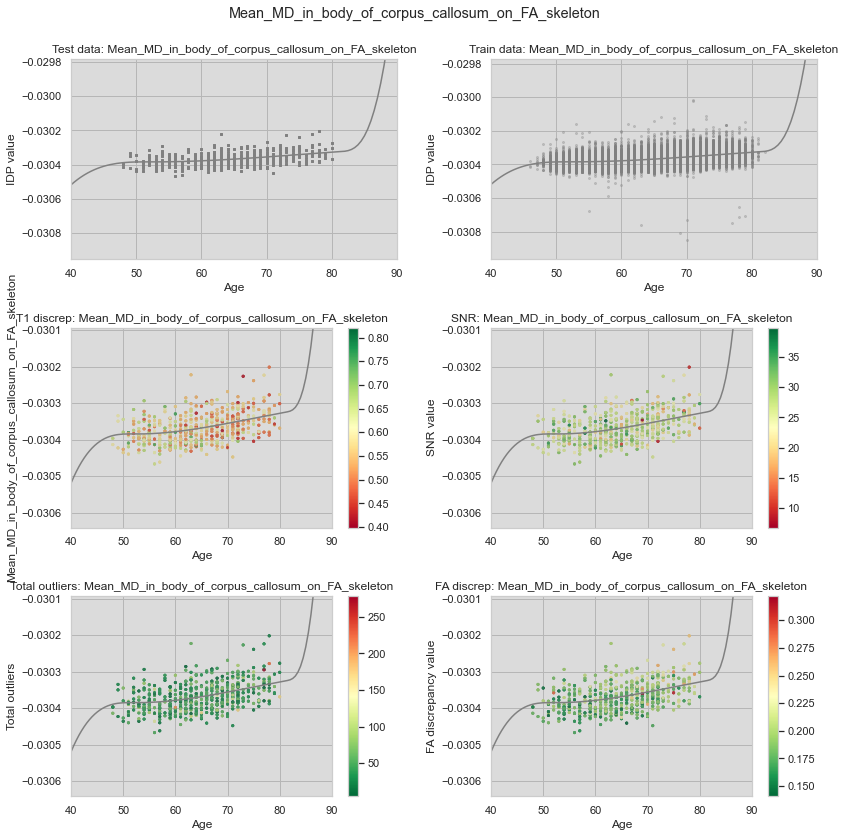

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.59414553e-05]), 'Rho': array([0.31186614]), 'pRho': array([6.37865985e-13]), 'SMSE': array([0.91417163]), 'EXPV': array([0.09469046])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.59414553e-05]), 'Rho': array([0.31186614]), 'pRho': array([6.37865985e-13]), 'SMSE': array([0.91417163]), 'EXPV': array([0.09469046])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.59414553e-05]), 'Rho': array([0.31186614]), 'pRho': array([6.37865985e-13]), 'SMSE': array([0.91417163]), 'EXPV': array([0.09469046])}


/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.59414553e-05]), 'Rho': array([0.31186614]), 'pRho': array([6.37865985e-13]), 'SMSE': array([0.91417163]), 'EXPV': array([0.09469046])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.59414553e-05]), 'Rho': array([0.31186614]), 'pRho': array([6.37865985e-13]), 'SMSE': array([0.91417163]), 'EXPV': array([0.09469046])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.59414553e-05]), 'Rho': array([0.31186614]), 'pRho': array([6.37865985e-13]), 'SMSE': array([0.91417163]), 'EXPV': array([0.09469046])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


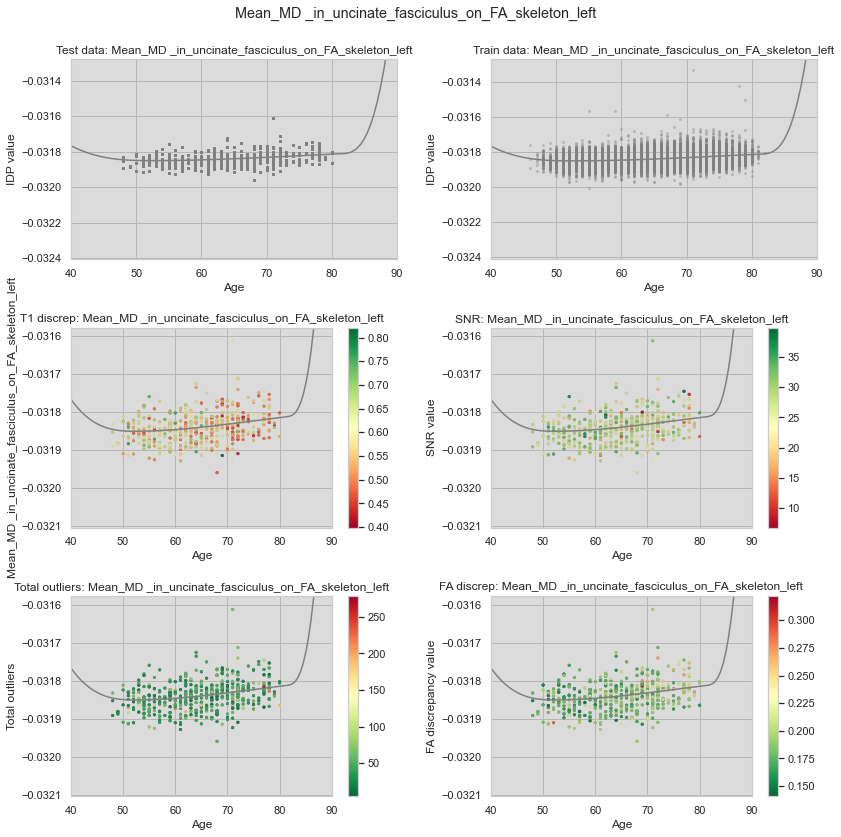

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.07593182e-05]), 'Rho': array([0.31994812]), 'pRho': array([1.44326454e-13]), 'SMSE': array([0.89901648]), 'EXPV': array([0.10130028])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.07593182e-05]), 'Rho': array([0.31994812]), 'pRho': array([1.44326454e-13]), 'SMSE': array([0.89901648]), 'EXPV': array([0.10130028])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.07593182e-05]), 'Rho': array([0.31994812]), 'pRho': array([1.44326454e-13]), 'SMSE': array([0.89901648]), 'EXPV': array([0.10130028])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3.07593182e-05]), 'Rho': array([0.31994812]), 'pRho': array([1.44326454e-13]), 'SMSE': array([0.89901648]), 'EXPV': array([0.10130028])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


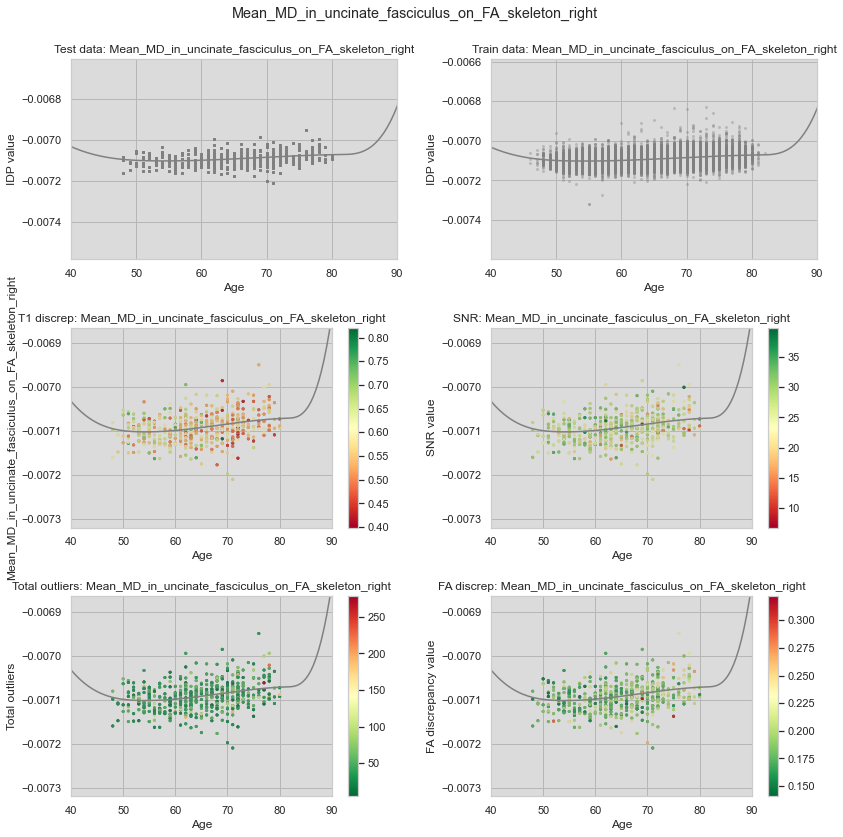

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.00028218]), 'Rho': array([0.49521617]), 'pRho': array([1.00333932e-33]), 'SMSE': array([0.7555302]), 'EXPV': array([0.24480509])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.00028218]), 'Rho': array([0.49521617]), 'pRho': array([1.00333932e-33]), 'SMSE': array([0.7555302]), 'EXPV': array([0.24480509])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.00028218]), 'Rho': array([0.49521617]), 'pRho': array([1.00333932e-33]), 'SMSE': array([0.7555302]), 'EXPV': array([0.24480509])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.00028218]), 'Rho': array([0.49521617]), 'pRho': array([1.00333932e-33]), 'SMSE': array([0.7555302]), 'EXPV': array([0.24480509])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


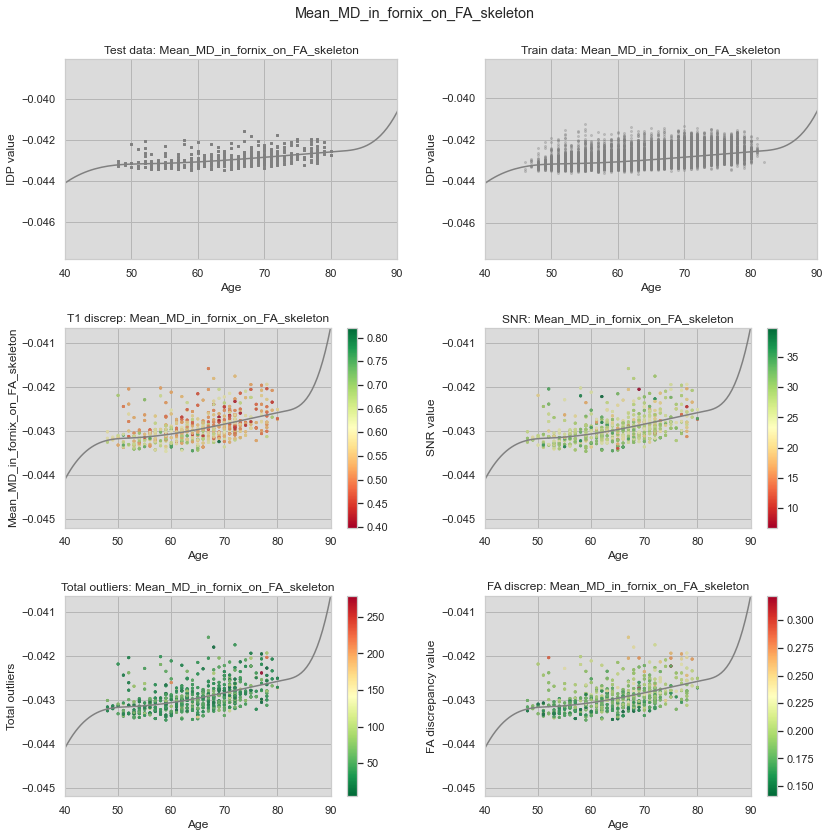

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([6.91346574e-05]), 'Rho': array([0.09407078]), 'pRho': array([0.03543205]), 'SMSE': array([0.99377579]), 'EXPV': array([0.00854673])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([6.91346574e-05]), 'Rho': array([0.09407078]), 'pRho': array([0.03543205]), 'SMSE': array([0.99377579]), 'EXPV': array([0.00854673])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([6.91346574e-05]), 'Rho': array([0.09407078]), 'pRho': array([0.03543205]), 'SMSE': array([0.99377579]), 'EXPV': array([0.00854673])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': arra

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([6.91346574e-05]), 'Rho': array([0.09407078]), 'pRho': array([0.03543205]), 'SMSE': array([0.99377579]), 'EXPV': array([0.00854673])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


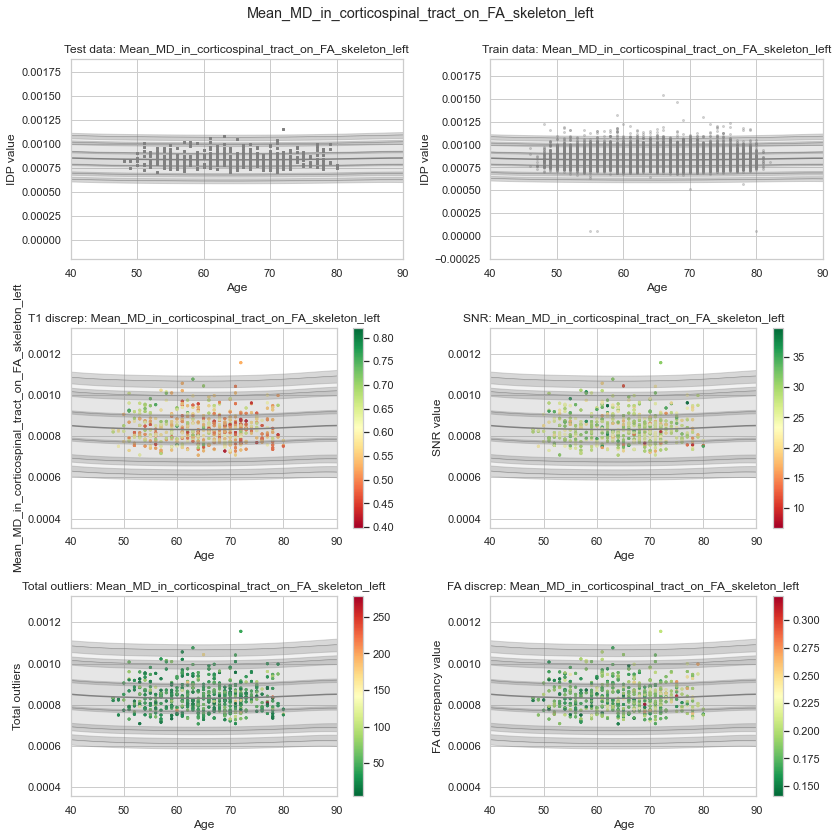

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03275015]), 'Rho': array([0.16055541]), 'pRho': array([0.00030551]), 'SMSE': array([0.97700142]), 'EXPV': array([0.02316768])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03275015]), 'Rho': array([0.16055541]), 'pRho': array([0.00030551]), 'SMSE': array([0.97700142]), 'EXPV': array([0.02316768])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03275015]), 'Rho': array([0.16055541]), 'pRho': array([0.00030551]), 'SMSE': array([0.97700142]), 'EXPV': array([0.02316768])}


/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03275015]), 'Rho': array([0.16055541]), 'pRho': array([0.00030551]), 'SMSE': array([0.97700142]), 'EXPV': array([0.02316768])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03275015]), 'Rho': array([0.16055541]), 'pRho': array([0.00030551]), 'SMSE': array([0.97700142]), 'EXPV': array([0.02316768])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03275015]), 'Rho': array([0.16055541]), 'pRho': array([0.00030551]), 'SMSE': array([0.97700142]), 'EXPV': array([0.02316768])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


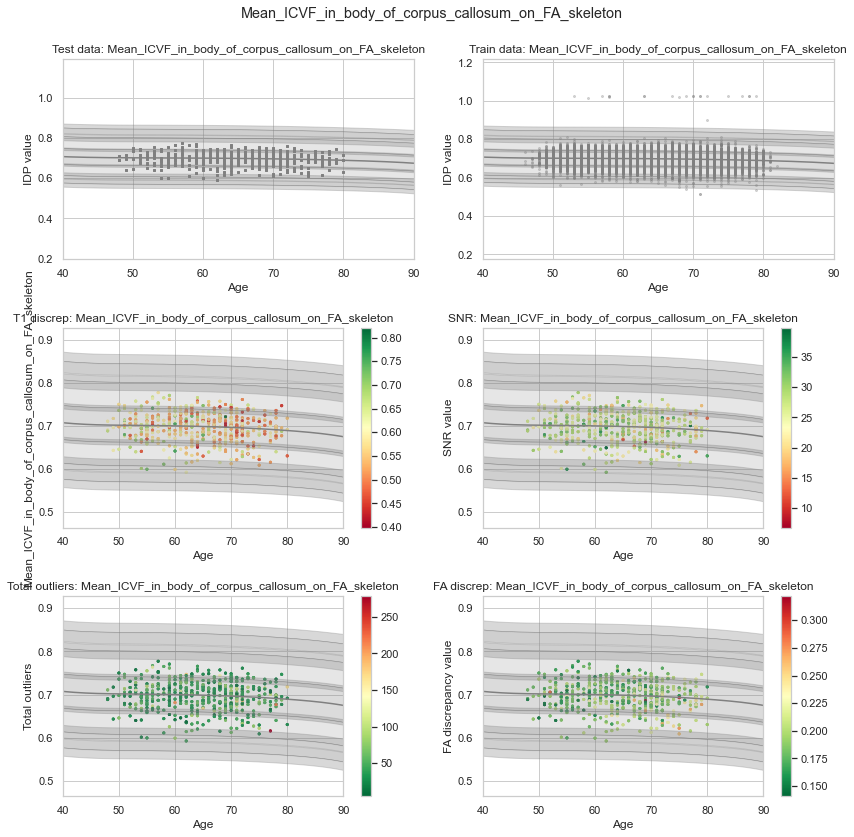

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02830092]), 'Rho': array([0.33387099]), 'pRho': array([9.95540877e-15]), 'SMSE': array([0.88961839]), 'EXPV': array([0.11074664])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02830092]), 'Rho': array([0.33387099]), 'pRho': array([9.95540877e-15]), 'SMSE': array([0.88961839]), 'EXPV': array([0.11074664])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02830092]), 'Rho': array([0.33387099]), 'pRho': array([9.95540877e-15]), 'SMSE': array([0.88961839]), 'EXPV': array([0.11074664])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': arra

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02830092]), 'Rho': array([0.33387099]), 'pRho': array([9.95540877e-15]), 'SMSE': array([0.88961839]), 'EXPV': array([0.11074664])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


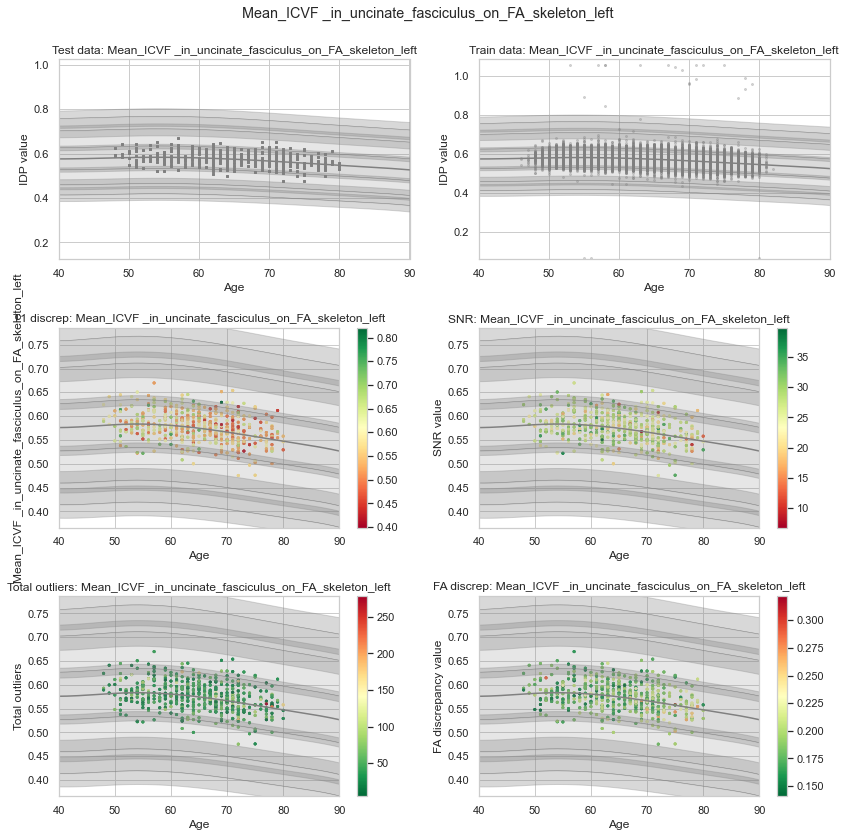

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02806532]), 'Rho': array([0.33348161]), 'pRho': array([1.07499068e-14]), 'SMSE': array([0.89004238]), 'EXPV': array([0.11011764])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02806532]), 'Rho': array([0.33348161]), 'pRho': array([1.07499068e-14]), 'SMSE': array([0.89004238]), 'EXPV': array([0.11011764])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02806532]), 'Rho': array([0.33348161]), 'pRho': array([1.07499068e-14]), 'SMSE': array([0.89004238]), 'EXPV': array([0.11011764])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': arra

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02806532]), 'Rho': array([0.33348161]), 'pRho': array([1.07499068e-14]), 'SMSE': array([0.89004238]), 'EXPV': array([0.11011764])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02806532]), 'Rho': array([0.33348161]), 'pRho': array([1.07499068e-14]), 'SMSE': array([0.89004238]), 'EXPV': array([0.11011764])}


/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


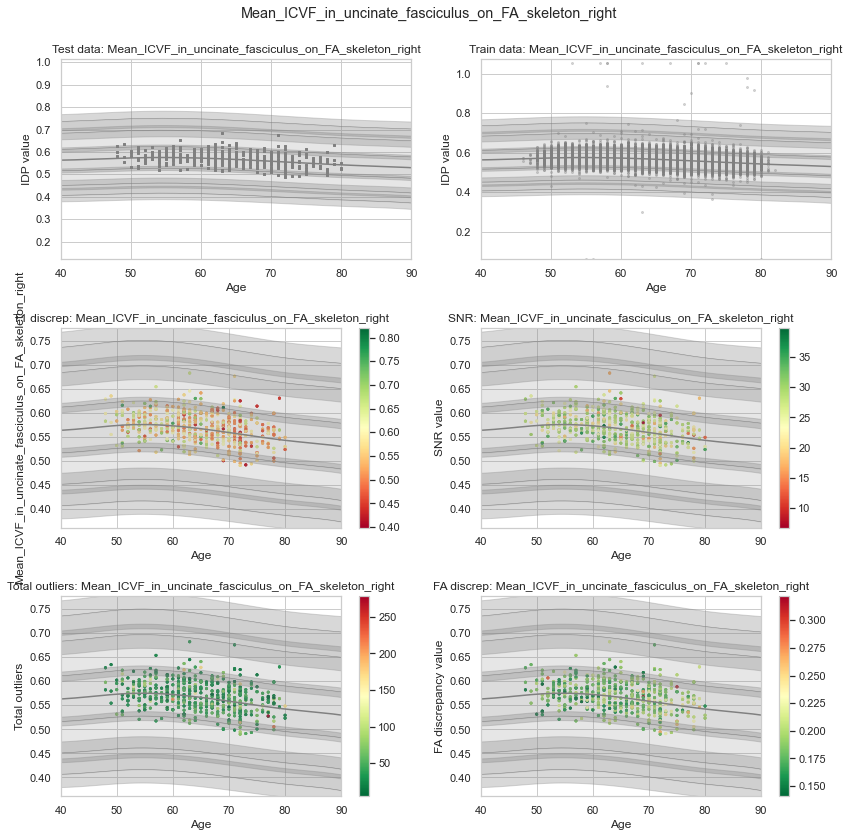

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06654167]), 'Rho': array([0.23242234]), 'pRho': array([1.3063383e-07]), 'SMSE': array([0.94728316]), 'EXPV': array([0.05297758])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06654167]), 'Rho': array([0.23242234]), 'pRho': array([1.3063383e-07]), 'SMSE': array([0.94728316]), 'EXPV': array([0.05297758])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06654167]), 'Rho': array([0.23242234]), 'pRho': array([1.3063383e-07]), 'SMSE': array([0.94728316]), 'EXPV': array([0.05297758])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06654167]), 'Rho': array([0.23242234]), 'pRho': array([1.3063383e-07]), 'SMSE': array([0.94728316]), 'EXPV': array([0.05297758])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06654167]), 'Rho': array([0.23242234]), 'pRho': array([1.3063383e-07]), 'SMSE': array([0.94728316]), 'EXPV': array([0.05297758])}


/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


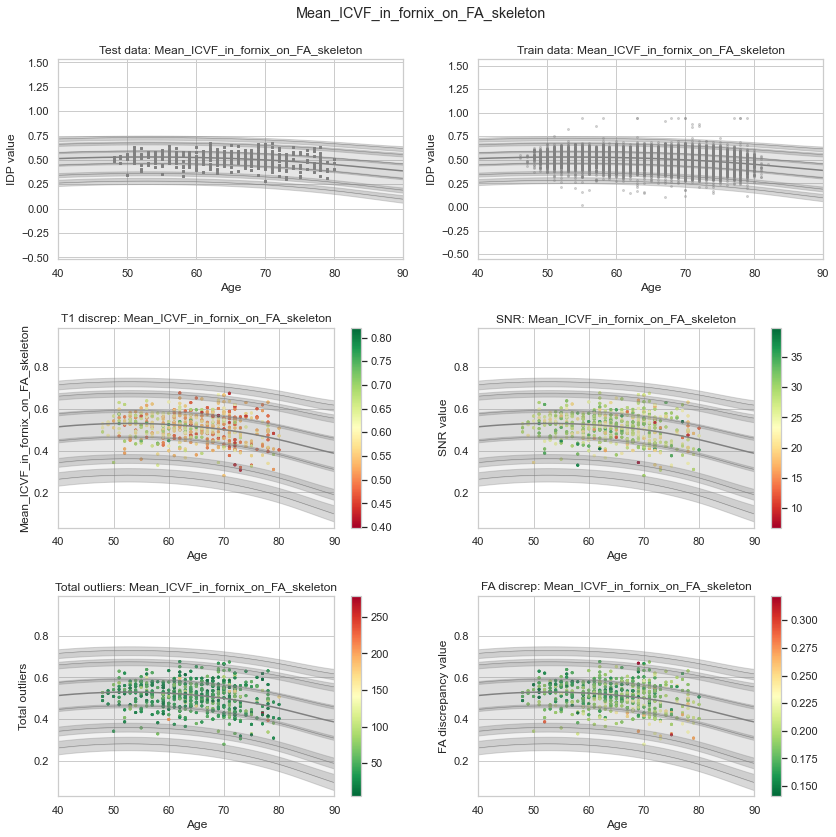

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04328906]), 'Rho': array([0.18281915]), 'pRho': array([3.75567802e-05]), 'SMSE': array([0.96759402]), 'EXPV': array([0.03299898])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04328906]), 'Rho': array([0.18281915]), 'pRho': array([3.75567802e-05]), 'SMSE': array([0.96759402]), 'EXPV': array([0.03299898])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04328906]), 'Rho': array([0.18281915]), 'pRho': array([3.75567802e-05]), 'SMSE': array([0.96759402]), 'EXPV': array([0.03299898])}


/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04328906]), 'Rho': array([0.18281915]), 'pRho': array([3.75567802e-05]), 'SMSE': array([0.96759402]), 'EXPV': array([0.03299898])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04328906]), 'Rho': array([0.18281915]), 'pRho': array([3.75567802e-05]), 'SMSE': array([0.96759402]), 'EXPV': array([0.03299898])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04328906]), 'Rho': array([0.18281915]), 'pRho': array([3.75567802e-05]), 'SMSE': array([0.96759402]), 'EXPV': array([0.03299898])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


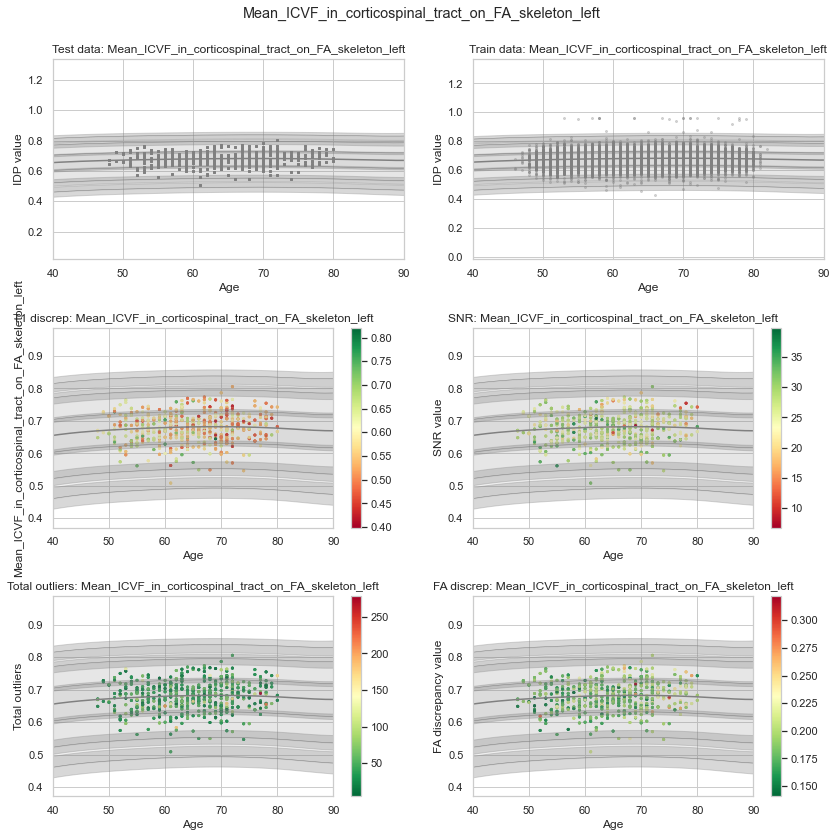

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04322999]), 'Rho': array([0.28237831]), 'pRho': array([9.73484499e-11]), 'SMSE': array([0.92241283]), 'EXPV': array([0.07860435])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04322999]), 'Rho': array([0.28237831]), 'pRho': array([9.73484499e-11]), 'SMSE': array([0.92241283]), 'EXPV': array([0.07860435])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04322999]), 'Rho': array([0.28237831]), 'pRho': array([9.73484499e-11]), 'SMSE': array([0.92241283]), 'EXPV': array([0.07860435])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...


/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


metrics: {'RMSE': array([0.04322999]), 'Rho': array([0.28237831]), 'pRho': array([9.73484499e-11]), 'SMSE': array([0.92241283]), 'EXPV': array([0.07860435])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04322999]), 'Rho': array([0.28237831]), 'pRho': array([9.73484499e-11]), 'SMSE': array([0.92241283]), 'EXPV': array([0.07860435])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04322999]), 'Rho': array([0.28237831]), 'pRho': array([9.73484499e-11]), 'SMSE': array([0.92241283]), 'EXPV': array([0.07860435])}


/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


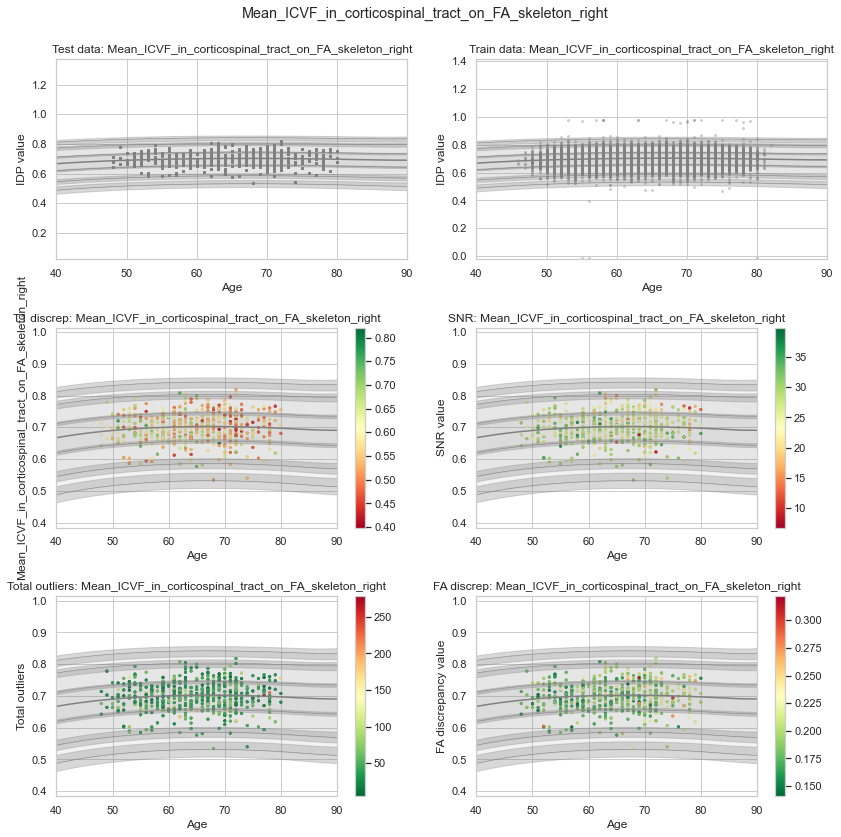

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01725591]), 'Rho': array([0.49782746]), 'pRho': array([3.90184716e-34]), 'SMSE': array([0.76092552]), 'EXPV': array([0.24718992])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01725591]), 'Rho': array([0.49782746]), 'pRho': array([3.90184716e-34]), 'SMSE': array([0.76092552]), 'EXPV': array([0.24718992])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01725591]), 'Rho': array([0.49782746]), 'pRho': array([3.90184716e-34]), 'SMSE': array([0.76092552]), 'EXPV': array([0.24718992])}


/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01725591]), 'Rho': array([0.49782746]), 'pRho': array([3.90184716e-34]), 'SMSE': array([0.76092552]), 'EXPV': array([0.24718992])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01725591]), 'Rho': array([0.49782746]), 'pRho': array([3.90184716e-34]), 'SMSE': array([0.76092552]), 'EXPV': array([0.24718992])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01725591]), 'Rho': array([0.49782746]), 'pRho': array([3.90184716e-34]), 'SMSE': array([0.76092552]), 'EXPV': array([0.24718992])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


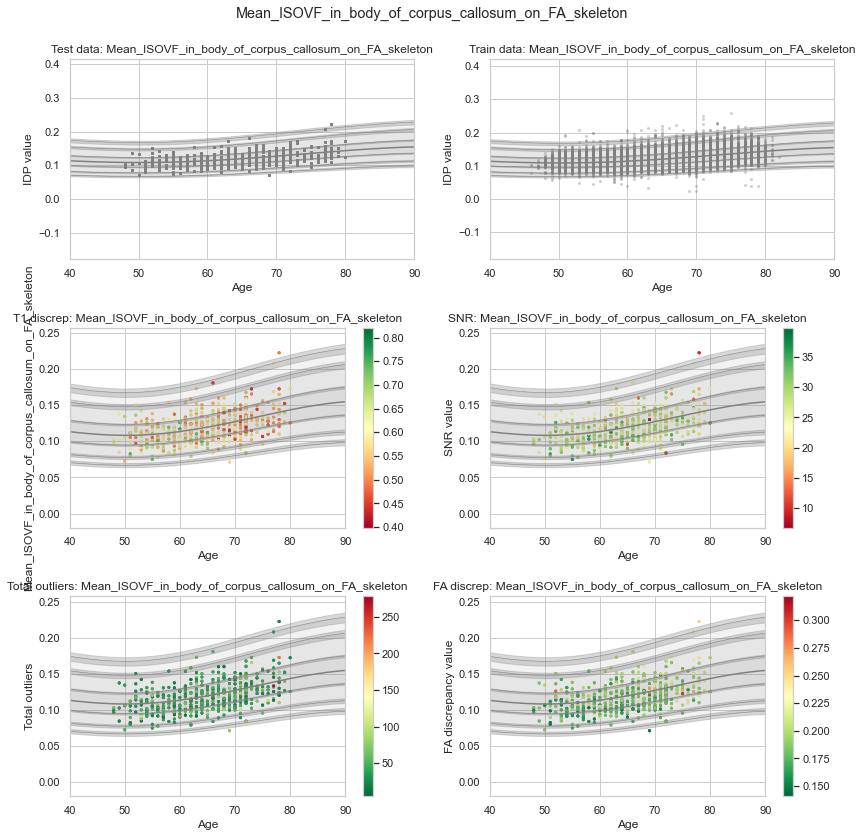

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01418145]), 'Rho': array([0.17043107]), 'pRho': array([0.00012457]), 'SMSE': array([1.0600328]), 'EXPV': array([0.02302973])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01418145]), 'Rho': array([0.17043107]), 'pRho': array([0.00012457]), 'SMSE': array([1.0600328]), 'EXPV': array([0.02302973])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01418145]), 'Rho': array([0.17043107]), 'pRho': array([0.00012457]), 'SMSE': array([1.0600328]), 'EXPV': array([0.02302973])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01418145])

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


metrics: {'RMSE': array([0.01418145]), 'Rho': array([0.17043107]), 'pRho': array([0.00012457]), 'SMSE': array([1.0600328]), 'EXPV': array([0.02302973])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01418145]), 'Rho': array([0.17043107]), 'pRho': array([0.00012457]), 'SMSE': array([1.0600328]), 'EXPV': array([0.02302973])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


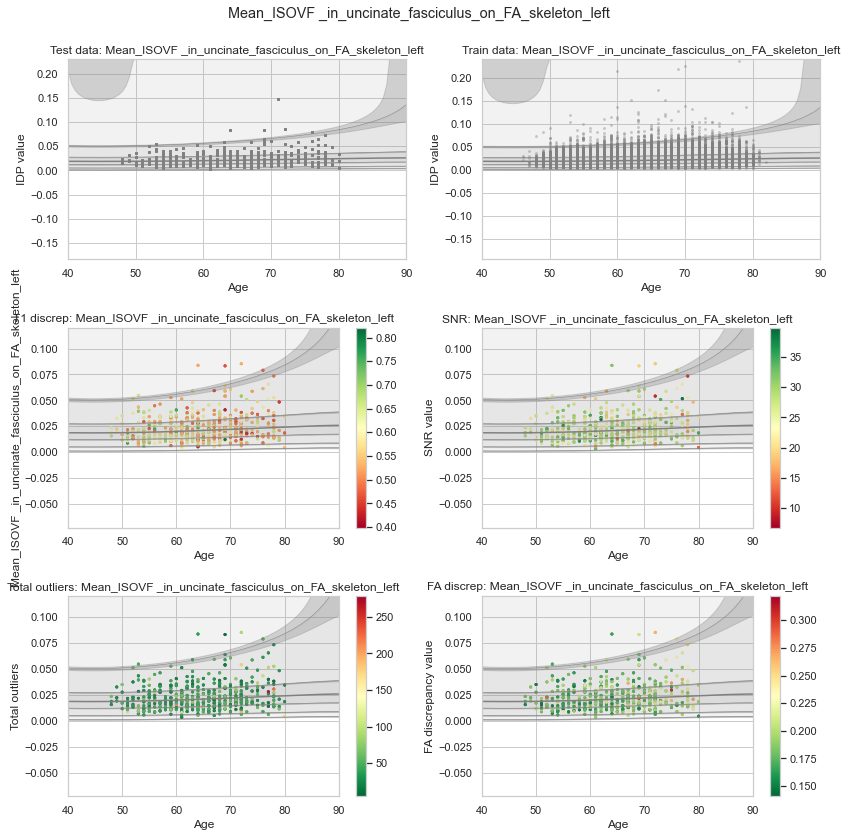

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0121364]), 'Rho': array([0.24179389]), 'pRho': array([3.81243891e-08]), 'SMSE': array([1.00050324]), 'EXPV': array([0.0499226])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0121364]), 'Rho': array([0.24179389]), 'pRho': array([3.81243891e-08]), 'SMSE': array([1.00050324]), 'EXPV': array([0.0499226])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0121364]), 'Rho': array([0.24179389]), 'pRho': array([3.81243891e-08]), 'SMSE': array([1.00050324]), 'EXPV': array([0.0499226])}


/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0121364]), 'Rho': array([0.24179389]), 'pRho': array([3.81243891e-08]), 'SMSE': array([1.00050324]), 'EXPV': array([0.0499226])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0121364]), 'Rho': array([0.24179389]), 'pRho': array([3.81243891e-08]), 'SMSE': array([1.00050324]), 'EXPV': array([0.0499226])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0121364]), 'Rho': array([0.24179389]), 'pRho': array([3.81243891e-08]), 'SMSE': array([1.00050324]), 'EXPV': array([0.0499226])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


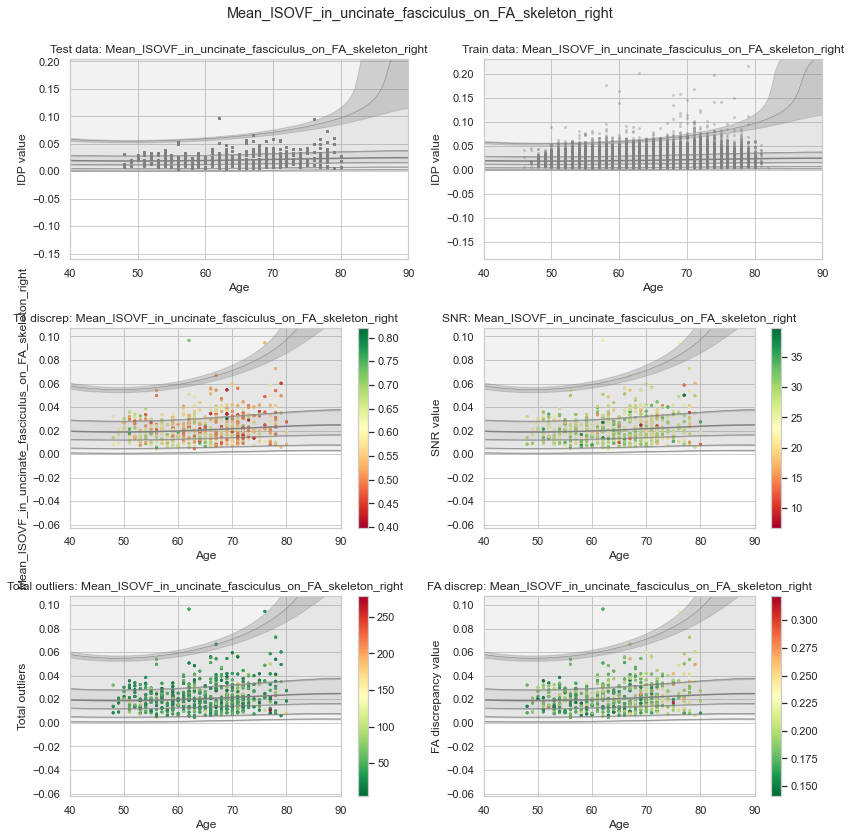

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11936112]), 'Rho': array([0.54596378]), 'pRho': array([1.82670518e-42]), 'SMSE': array([0.70887682]), 'EXPV': array([0.29792001])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11936112]), 'Rho': array([0.54596378]), 'pRho': array([1.82670518e-42]), 'SMSE': array([0.70887682]), 'EXPV': array([0.29792001])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11936112]), 'Rho': array([0.54596378]), 'pRho': array([1.82670518e-42]), 'SMSE': array([0.70887682]), 'EXPV': array([0.29792001])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': arra

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


metrics: {'RMSE': array([0.11936112]), 'Rho': array([0.54596378]), 'pRho': array([1.82670518e-42]), 'SMSE': array([0.70887682]), 'EXPV': array([0.29792001])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11936112]), 'Rho': array([0.54596378]), 'pRho': array([1.82670518e-42]), 'SMSE': array([0.70887682]), 'EXPV': array([0.29792001])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


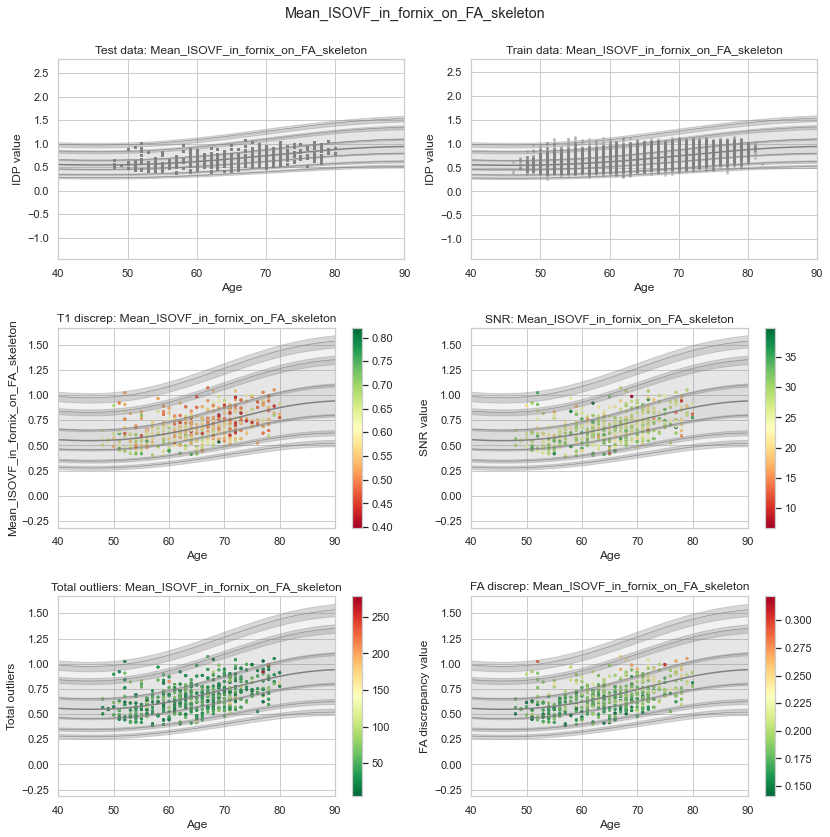

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04571328]), 'Rho': array([0.08585862]), 'pRho': array([0.05500798]), 'SMSE': array([0.9987373]), 'EXPV': array([0.00617926])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04571328]), 'Rho': array([0.08585862]), 'pRho': array([0.05500798]), 'SMSE': array([0.9987373]), 'EXPV': array([0.00617926])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04571328]), 'Rho': array([0.08585862]), 'pRho': array([0.05500798]), 'SMSE': array([0.9987373]), 'EXPV': array([0.00617926])}


/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04571328]), 'Rho': array([0.08585862]), 'pRho': array([0.05500798]), 'SMSE': array([0.9987373]), 'EXPV': array([0.00617926])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04571328]), 'Rho': array([0.08585862]), 'pRho': array([0.05500798]), 'SMSE': array([0.9987373]), 'EXPV': array([0.00617926])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04571328]), 'Rho': array([0.08585862]), 'pRho': array([0.05500798]), 'SMSE': array([0.9987373]), 'EXPV': array([0.00617926])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


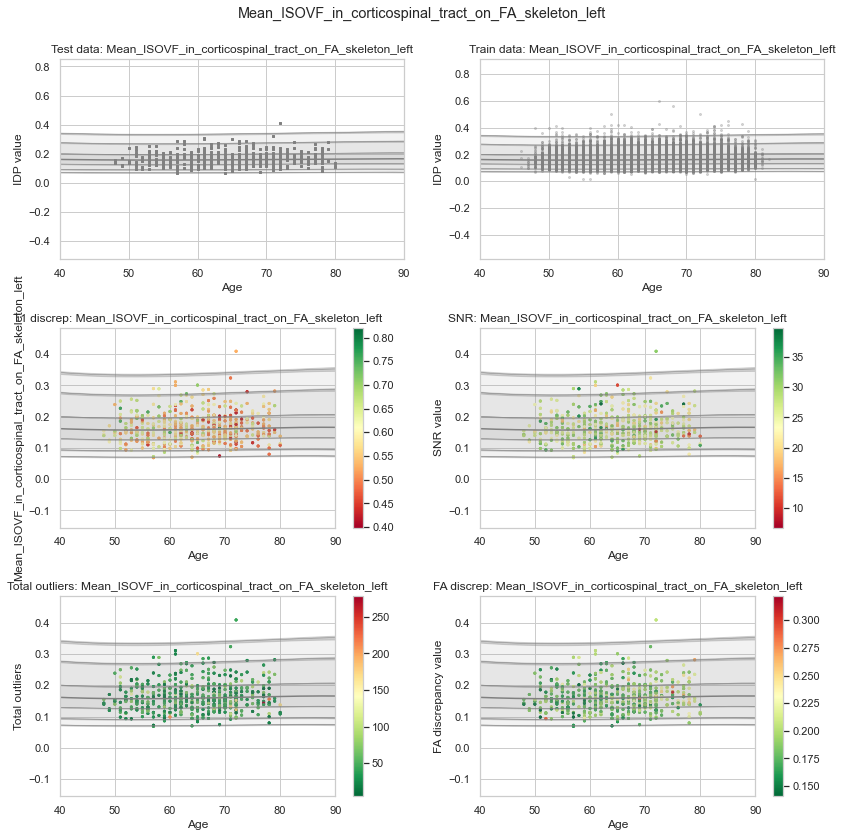

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.05512299]), 'Rho': array([0.13336526]), 'pRho': array([0.00278069]), 'SMSE': array([1.00280271]), 'EXPV': array([0.01015687])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.05512299]), 'Rho': array([0.13336526]), 'pRho': array([0.00278069]), 'SMSE': array([1.00280271]), 'EXPV': array([0.01015687])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.05512299]), 'Rho': array([0.13336526]), 'pRho': array([0.00278069]), 'SMSE': array([1.00280271]), 'EXPV': array([0.01015687])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0551229

/tmp/ipykernel_6624/2098694207.py:333: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:455: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_6624/2098694207.py:577: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.05512299]), 'Rho': array([0.13336526]), 'pRho': array([0.00278069]), 'SMSE': array([1.00280271]), 'EXPV': array([0.01015687])}


/tmp/ipykernel_6624/2098694207.py:699: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


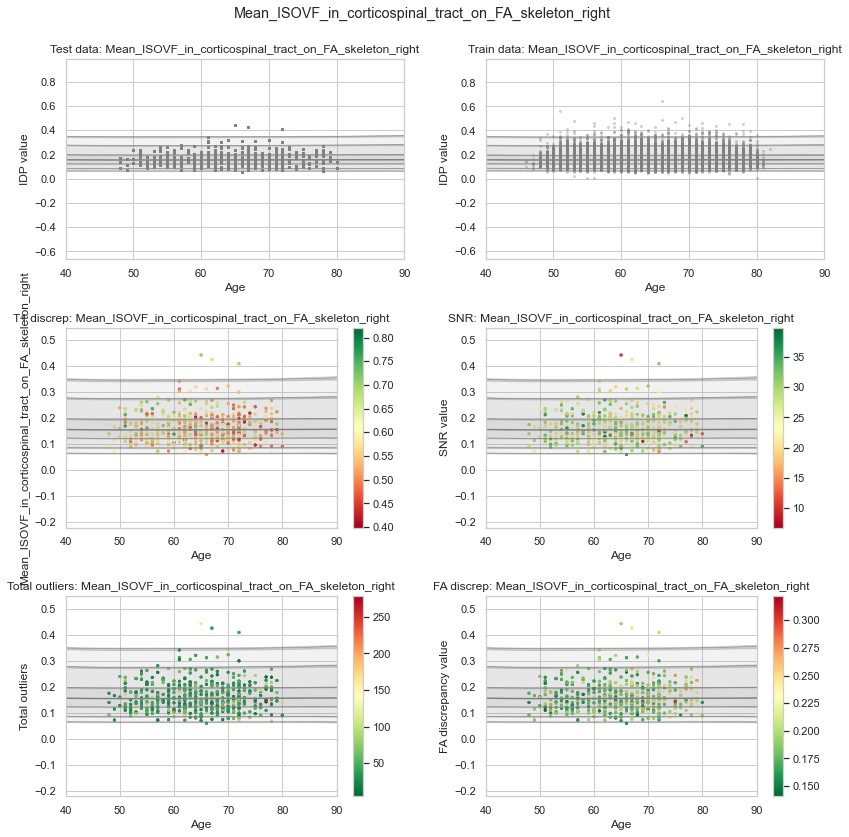

In [75]:
for idp_num, idp in enumerate(idp_ids):
#     if idp_num == 7:
        # TEST DATA #####################################################################################################
        fig1 = plt.figure(figsize=(12, 12))

        plt.subplot(3,2,1)
        sns.set(style='whitegrid')
        idp_dir = os.path.join(out_dir, idp)
        os.chdir(idp_dir)

        # load the true data points
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

        # set up the covariates for the dummy data
        print('Making predictions with dummy covariates (for visualisation)')
        yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')

        # load the normative model
        with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 

        # get the warp and warp parameters
        W = nm.blr.warp
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

        # first, we warp predictions for the true data and compute evaluation metrics
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
        print('metrics:', evaluate(y_te, med_te))

        # then, we warp dummy predictions to create the plots
        med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

        # extract the different variance components to visualise
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
        s2n = 1/beta # variation (aleatoric uncertainty)
        s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

        # plot the data points
        y_te_rescaled_all = np.zeros_like(y_te)
        for sid, site in enumerate(site_ids_te):
            # plot the true test data points 
            if all(elem in site_ids_tr for elem in site_ids_te):
                # all data in the test set are present in the training set

                # first, we select the data points belonging to this particular site
                idx = range(0, len(X_te[:,2]))
                if len(idx) == 0:
                    print('No data for site', sid, site, 'skipping...')
                    continue

                # then directly adjust the data
                idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
                y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
            else:
                # we need to adjust the data based on the adaptation dataset 

                # first, select the data point belonging to this particular site
                idx = range(0, len(X_te[:,2]))

                # load the adaptation data
                y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
                X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
                idx_a = np.where(np.bitwise_and(X_ad[:,2] <2, (df_ad['site'] == site).to_numpy()))[0]
                if len(idx) < 2 or len(idx_a) < 2:
                    print('Insufficent data for site', sid, site, 'skipping...')
                    continue

                # adjust and rescale the data
                y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                   X_ad[idx_a,:], 
                                                                   np.squeeze(y_ad[idx_a]), 
                                                                   Xs=None, 
                                                                   ys=np.squeeze(y_te[idx]))
            # plot the (adjusted) data points
            plt.scatter(X_te[idx,1], y_te_rescaled, s=4, color=clr, alpha = 1)

        # plot the median of the dummy data
        plt.plot(xx, med, clr)

        # fill the gaps in between the centiles
        junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
        plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

        # make the width of each centile proportional to the epistemic uncertainty
        junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
        junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
        plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

        # plot actual centile lines
        plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

        plt.xlabel('Age')
        plt.ylabel('IDP value') 
        plt.title('Test data: ' + idp)
        plt.xlim((40,90))
        plt.ylim((np.mean(y_te_rescaled)-15*np.std(y_te_rescaled)), (np.mean(y_te_rescaled)+15*np.std(y_te_rescaled)))

        # TRAIN DATA #####################################################################################################
        plt.subplot(3,2,2)
        sns.set(style='whitegrid')
        idp_dir = os.path.join(out_dir, idp)
        os.chdir(idp_dir)

        # load the true data points
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
        y_tr = load_2d(os.path.join(idp_dir, 'resp_tr.txt'))

        # set up the covariates for the dummy data
        print('Making predictions with dummy covariates (for visualisation)')
        yhat, s2 = predict(cov_file_dummy, 
                           alg = 'blr', 
                           respfile = None, 
                           model_path = os.path.join(idp_dir,'Models'), 
                           outputsuffix = '_dummy')

        # load the normative model
        with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 

        # get the warp and warp parameters
        W = nm.blr.warp
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

        # first, we warp predictions for the true data and compute evaluation metrics
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
        print('metrics:', evaluate(y_te, med_te))

        # then, we warp dummy predictions to create the plots
        med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

        # extract the different variance components to visualise
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
        s2n = 1/beta # variation (aleatoric uncertainty)
        s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

        # plot the data points
        y_te_rescaled_all = np.zeros_like(y_te)
        for sid, site in enumerate(site_ids_te):
            # plot the true test data points 
            if all(elem in site_ids_tr for elem in site_ids_te):
                # all data in the test set are present in the training set

                # first, we select the data points belonging to this particular site
                idx = range(0, len(X_tr[:,2]))
                if len(idx) == 0:
                    print('No data for site', sid, site, 'skipping...')
                    continue

                # then directly adjust the data
        #             idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
                idx_dummy = np.bitwise_and(X_dummy[:,1] > df_tr['age'].min(), X_dummy[:,1] < df_tr['age'].max())
        #             y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
                y_tr_rescaled = y_tr[idx] - np.median(y_tr[idx]) + np.median(med[idx_dummy])
            else:
                print('else')
                # we need to adjust the data based on the adaptation dataset 

                # first, select the data point belonging to this particular site
                idx = range(0, len(X_te[:,2]))

                # load the adaptation data
                y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
                X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
                idx_a = np.where(np.bitwise_and(X_ad[:,2] <2, (df_ad['site'] == site).to_numpy()))[0]
                if len(idx) < 2 or len(idx_a) < 2:
                    print('Insufficent data for site', sid, site, 'skipping...')
                    continue

                # adjust and rescale the data
                y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                       X_ad[idx_a,:], 
                                                                       np.squeeze(y_ad[idx_a]), 
                                                                       Xs=None, 
                                                                       ys=np.squeeze(y_te[idx]))
                y_tr_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                       X_ad[idx_a,:], 
                                                                       np.squeeze(y_ad[idx_a]), 
                                                                       Xs=None, 
                                                                       ys=np.squeeze(y_tr[idx]))
            # plot the (adjusted) data points
            plt.scatter(df_tr['age'], y_tr_rescaled, s=4, color=clr, alpha = 0.1)

        # plot the median of the dummy data
        plt.plot(xx, med, clr)

        # fill the gaps in between the centiles
        junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
        plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

        # make the width of each centile proportional to the epistemic uncertainty
        junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
        junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
        plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

        # plot actual centile lines
        plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

        plt.xlabel('Age')
        plt.ylabel('IDP value') 
        plt.title('Train data: ' + idp)

        plt.xlim((40,90))
        plt.ylim((np.mean(y_tr_rescaled)-15*np.std(y_tr_rescaled)), (np.mean(y_tr_rescaled)+15*np.std(y_tr_rescaled)))

        # T1 vs DWI discrepancy #####################################################################################################
        plt.subplot(3,2,3)
        sns.set(style='whitegrid')
        clr = 'gray'
        idp_dir = os.path.join(out_dir, idp)
        os.chdir(idp_dir)

        # load the true data points
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

        # set up the covariates for the dummy data
        print('Making predictions with dummy covariates (for visualisation)')
        yhat, s2 = predict(cov_file_dummy, 
                           alg = 'blr', 
                           respfile = None, 
                           model_path = os.path.join(idp_dir,'Models'), 
                           outputsuffix = '_dummy')

        # load the normative model
        with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 

        # get the warp and warp parameters
        W = nm.blr.warp
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

        # first, we warp predictions for the true data and compute evaluation metrics
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
        print('metrics:', evaluate(y_te, med_te))

        # then, we warp dummy predictions to create the plots
        med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

        # extract the different variance components to visualise
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
        s2n = 1/beta # variation (aleatoric uncertainty)
        s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

        # plot the data points
        y_te_rescaled_all = np.zeros_like(y_te)
        for sid, site in enumerate(site_ids_te):
            # plot the true test data points 
            if all(elem in site_ids_tr for elem in site_ids_te):
                # all data in the test set are present in the training set

                # first, we select the data points belonging to this particular site
                idx = range(0, len(X_te[:,2]))
                if len(idx) == 0:
                    print('No data for site', sid, site, 'skipping...')
                    continue

                # then directly adjust the data
                idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
                y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
            else:
                # we need to adjust the data based on the adaptation dataset 

                # first, select the data point belonging to this particular site
                idx = np.where(np.bitwise_and(X_te[:,2] <2, (df_te['site'] == site).to_numpy()))[0]

                # load the adaptation data
                y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
                X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
                idx_a = np.where(np.bitwise_and(X_ad[:,2] <2, (df_ad['site'] == site).to_numpy()))[0]
                if len(idx) < 2 or len(idx_a) < 2:
                    print('Insufficent data for site', sid, site, 'skipping...')
                    continue

                # adjust and rescale the data
                y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                       X_ad[idx_a,:], 
                                                                       np.squeeze(y_ad[idx_a]), 
                                                                       Xs=None, 

                                                                       ys=np.squeeze(y_te[idx]))
            # plot the (adjusted) data points
            labels = np.array(qc500_features["T1_discrep"])
        #         cmap = matplotlib.colors.ListedColormap(['red', 'green'])
            plt.scatter(X_te[:,1], y_te_rescaled, s=4, c=labels, cmap = 'RdYlGn', alpha = 1)
        plt.colorbar()    
        # plot the median of the dummy data
        plt.plot(xx, med, clr)

        # fill the gaps in between the centiles
        junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
        plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

        # make the width of each centile proportional to the epistemic uncertainty
        junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
        junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
        plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

        # plot actual centile lines
        plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

        plt.xlabel('Age')
        plt.ylabel(idp) 
        plt.title('T1 discrep: ' +idp)
        plt.xlim((40,90))
        plt.ylim((np.mean(y_te_rescaled)-7*np.std(y_te_rescaled)), (np.mean(y_te_rescaled)+7*np.std(y_te_rescaled)))

        # SNR #####################################################################################################
        plt.subplot(3,2,4)
        sns.set(style='whitegrid')
        clr = 'gray'
        idp_dir = os.path.join(out_dir, idp)
        os.chdir(idp_dir)

        # load the true data points
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

        # set up the covariates for the dummy data
        print('Making predictions with dummy covariates (for visualisation)')
        yhat, s2 = predict(cov_file_dummy, 
                           alg = 'blr', 
                           respfile = None, 
                           model_path = os.path.join(idp_dir,'Models'), 
                           outputsuffix = '_dummy')

        # load the normative model
        with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 

        # get the warp and warp parameters
        W = nm.blr.warp
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

        # first, we warp predictions for the true data and compute evaluation metrics
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
        print('metrics:', evaluate(y_te, med_te))

        # then, we warp dummy predictions to create the plots
        med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

        # extract the different variance components to visualise
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
        s2n = 1/beta # variation (aleatoric uncertainty)
        s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

        # plot the data points
        y_te_rescaled_all = np.zeros_like(y_te)
        for sid, site in enumerate(site_ids_te):
            # plot the true test data points 
            if all(elem in site_ids_tr for elem in site_ids_te):
                # all data in the test set are present in the training set

                # first, we select the data points belonging to this particular site
                idx = range(0, len(X_te[:,2]))
                if len(idx) == 0:
                    print('No data for site', sid, site, 'skipping...')
                    continue

                # then directly adjust the data
                idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
                y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
            else:
                # we need to adjust the data based on the adaptation dataset 

                # first, select the data point belonging to this particular site
                idx = np.where(np.bitwise_and(X_te[:,2] <2, (df_te['site'] == site).to_numpy()))[0]

                # load the adaptation data
                y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
                X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
                idx_a = np.where(np.bitwise_and(X_ad[:,2] <2, (df_ad['site'] == site).to_numpy()))[0]
                if len(idx) < 2 or len(idx_a) < 2:
                    print('Insufficent data for site', sid, site, 'skipping...')
                    continue

                # adjust and rescale the data
                y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                       X_ad[idx_a,:], 
                                                                       np.squeeze(y_ad[idx_a]), 
                                                                       Xs=None, 

                                                                       ys=np.squeeze(y_te[idx]))
            # plot the (adjusted) data points
            labels = np.array(qc500_features["SNR"])
        #         cmap = matplotlib.colors.ListedColormap(['red', 'green'])
            plt.scatter(X_te[:,1], y_te_rescaled, s=4, c=labels, cmap = 'RdYlGn', alpha = 1)
        plt.colorbar()    
        # plot the median of the dummy data
        plt.plot(xx, med, clr)

        # fill the gaps in between the centiles
        junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
        plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

        # make the width of each centile proportional to the epistemic uncertainty
        junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
        junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
        plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

        # plot actual centile lines
        plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

        plt.xlabel('Age')
        plt.ylabel('SNR value') 
        plt.title('SNR: ' + idp)
        plt.xlim((40,90))
        plt.ylim((np.mean(y_te_rescaled)-7*np.std(y_te_rescaled)), (np.mean(y_te_rescaled)+7*np.std(y_te_rescaled)))

        # Total Outliers #####################################################################################################
        plt.subplot(3,2,5)
        sns.set(style='whitegrid')
        clr = 'gray'
        idp_dir = os.path.join(out_dir, idp)
        os.chdir(idp_dir)

        # load the true data points
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

        # set up the covariates for the dummy data
        print('Making predictions with dummy covariates (for visualisation)')
        yhat, s2 = predict(cov_file_dummy, 
                           alg = 'blr', 
                           respfile = None, 
                           model_path = os.path.join(idp_dir,'Models'), 
                           outputsuffix = '_dummy')

        # load the normative model
        with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 

        # get the warp and warp parameters
        W = nm.blr.warp
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

        # first, we warp predictions for the true data and compute evaluation metrics
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
        print('metrics:', evaluate(y_te, med_te))

        # then, we warp dummy predictions to create the plots
        med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

        # extract the different variance components to visualise
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
        s2n = 1/beta # variation (aleatoric uncertainty)
        s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

        # plot the data points
        y_te_rescaled_all = np.zeros_like(y_te)
        for sid, site in enumerate(site_ids_te):
            # plot the true test data points 
            if all(elem in site_ids_tr for elem in site_ids_te):
                # all data in the test set are present in the training set

                # first, we select the data points belonging to this particular site
                idx = range(0, len(X_te[:,2]))
                if len(idx) == 0:
                    print('No data for site', sid, site, 'skipping...')
                    continue

                # then directly adjust the data
                idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
                y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
            else:
                # we need to adjust the data based on the adaptation dataset 

                # first, select the data point belonging to this particular site
                idx = np.where(np.bitwise_and(X_te[:,2] <2, (df_te['site'] == site).to_numpy()))[0]

                # load the adaptation data
                y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
                X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
                idx_a = np.where(np.bitwise_and(X_ad[:,2] <2, (df_ad['site'] == site).to_numpy()))[0]
                if len(idx) < 2 or len(idx_a) < 2:
                    print('Insufficent data for site', sid, site, 'skipping...')
                    continue

                # adjust and rescale the data
                y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                       X_ad[idx_a,:], 
                                                                       np.squeeze(y_ad[idx_a]), 
                                                                       Xs=None, 

                                                                       ys=np.squeeze(y_te[idx]))
            # plot the (adjusted) data points
            labels = np.array(qc500_features["No_outliers_corrected"])
        #         cmap = matplotlib.colors.ListedColormap(['red', 'green'])
            plt.scatter(X_te[:,1], y_te_rescaled, s=4, c=labels, cmap = 'RdYlGn_r', alpha = 1)
        plt.colorbar()    
        # plot the median of the dummy data
        plt.plot(xx, med, clr)

        # fill the gaps in between the centiles
        junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
        plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

        # make the width of each centile proportional to the epistemic uncertainty
        junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
        junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
        plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

        # plot actual centile lines
        plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

        plt.xlabel('Age')
        plt.ylabel('Total outliers') 
        plt.title('Total outliers: ' + idp)
        plt.xlim((40,90))
        plt.ylim((np.mean(y_te_rescaled)-7*np.std(y_te_rescaled)), (np.mean(y_te_rescaled)+7*np.std(y_te_rescaled)))

        # FA vs T1 discrepancy #####################################################################################################
        plt.subplot(3,2,6)
        sns.set(style='whitegrid')
        clr = 'gray'
        idp_dir = os.path.join(out_dir, idp)
        os.chdir(idp_dir)

        # load the true data points
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

        # set up the covariates for the dummy data
        print('Making predictions with dummy covariates (for visualisation)')
        yhat, s2 = predict(cov_file_dummy, 
                           alg = 'blr', 
                           respfile = None, 
                           model_path = os.path.join(idp_dir,'Models'), 
                           outputsuffix = '_dummy')

        # load the normative model
        with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 

        # get the warp and warp parameters
        W = nm.blr.warp
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

        # first, we warp predictions for the true data and compute evaluation metrics
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
        print('metrics:', evaluate(y_te, med_te))

        # then, we warp dummy predictions to create the plots
        med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

        # extract the different variance components to visualise
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
        s2n = 1/beta # variation (aleatoric uncertainty)
        s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

        # plot the data points
        y_te_rescaled_all = np.zeros_like(y_te)
        for sid, site in enumerate(site_ids_te):
            # plot the true test data points 
            if all(elem in site_ids_tr for elem in site_ids_te):
                # all data in the test set are present in the training set

                # first, we select the data points belonging to this particular site
                idx = range(0, len(X_te[:,2]))
                if len(idx) == 0:
                    print('No data for site', sid, site, 'skipping...')
                    continue

                # then directly adjust the data
                idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
                y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
            else:
                # we need to adjust the data based on the adaptation dataset 

                # first, select the data point belonging to this particular site
                idx = np.where(np.bitwise_and(X_te[:,2] <2, (df_te['site'] == site).to_numpy()))[0]

                # load the adaptation data
                y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
                X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
                idx_a = np.where(np.bitwise_and(X_ad[:,2] <2, (df_ad['site'] == site).to_numpy()))[0]
                if len(idx) < 2 or len(idx_a) < 2:
                    print('Insufficent data for site', sid, site, 'skipping...')
                    continue

                # adjust and rescale the data
                y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                       X_ad[idx_a,:], 
                                                                       np.squeeze(y_ad[idx_a]), 
                                                                       Xs=None, 

                                                                       ys=np.squeeze(y_te[idx]))
            # plot the (adjusted) data points
            labels = np.array(qc500_features["FA_qc"])
        #         cmap = matplotlib.colors.ListedColormap(['red', 'green'])
            plt.scatter(X_te[:,1], y_te_rescaled, s=4, c=labels, cmap = 'RdYlGn_r', alpha = 1)
        plt.colorbar()    
        # plot the median of the dummy data
        plt.plot(xx, med, clr)

        # fill the gaps in between the centiles
        junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
        plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

        # make the width of each centile proportional to the epistemic uncertainty
        junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
        junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
        plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

        # plot actual centile lines
        plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

        plt.xlabel('Age')
        plt.ylabel('FA discrepancy value') 
        plt.title('FA discrep: ' + idp)
        plt.xlim((40,90))
        plt.ylim((np.mean(y_te_rescaled)-7*np.std(y_te_rescaled)), (np.mean(y_te_rescaled)+7*np.std(y_te_rescaled)))

        fig1.tight_layout(pad = 2)
        plt.suptitle(idp)
        fig1.subplots_adjust(top=0.92)
        plt.savefig(os.path.join(idp_dir, 'centile_plots'))
        plt.show()
os.chdir(out_dir)

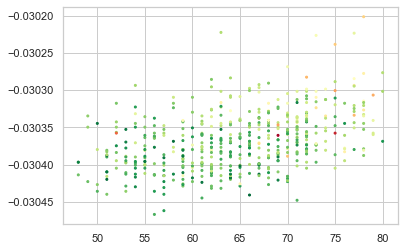

In [35]:
plt.scatter(X_te[:,1], y_te_rescaled, s=4, c=labels, cmap = 'RdYlGn_r', alpha = 1)